In [219]:
# pip installs
# !pip install pyspellchecker
# !pip install seaborn==0.11.2
# !pip install -U textblob
# !pip install nltk
# nltk.download('punkt')
# !pip install multimodal-transformers --user
## always restart kernel after installation
# !pip install tensorboard

In [5]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import (AutoTokenizer, AutoConfig, Trainer, EvalPrediction, set_seed)
from textblob import TextBlob
from transformers.training_args import TrainingArguments
from multimodal_transformers.data import load_data_from_folder
from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

C:\Users\tan_k\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [27]:
nltk.download('punkt')
sent = "asfdnsdf"
blob = TextBlob(sent)
for sent in blob.sentences:
    print(sent.sentiment.polarity)
    print(sent.sentiment.subjectivity)

0.0
0.0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tan_k\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
import seaborn as sns
sns.__version__

'0.11.2'

# Data Preparation

In [3]:
df = pd.read_csv(r'C:\Users\tan_k\Predicting Effective Arguments_kaggle\data_df.csv')

In [4]:
train_df, val_df= np.split(df.sample(frac=1), [int(.9*len(df))])
print('Num examples train-val')
# print(len(train_df), len(val_df), len(test_df))
print(len(train_df), len(val_df))
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
# test_df.to_csv('test.csv')

Num examples train-val
33088 3677


In [5]:
train_df.head()

,discourse_text,discourse_type,discourse_effectiveness,source,spelling,count,polarity,subjectivity
20670,This world is turning into a darker place. The...,Lead,1,0,0,61,0.000000,0.000000
32237,I find that would be much easier. people would...,Evidence,2,0,0,25,0.350000,0.512500
2007,The author does not strongly support the idea ...,Position,1,0,1,35,-0.002083,0.610417
31482,Another benefit to online education is the stu...,Claim,1,0,0,13,0.000000,0.000000
17219,"I understand that ""the winning candidate's sha...",Counterclaim,1,0,0,34,0.383333,0.654167


In [6]:
val_df.head()

,discourse_text,discourse_type,discourse_effectiveness,source,spelling,count,polarity,subjectivity
10691,First of all i am against using this technolog...,Claim,2,0,1,41,0.120000,0.456667
18809,Another positive to driverless cars are the en...,Claim,1,0,1,22,0.250000,0.612500
24083,I do not like the Electoral College. The Elect...,Lead,0,0,1,63,0.130357,0.558929
24817,"Joe and I have different belifes, although I a...",Evidence,2,0,5,75,0.000000,0.000000
13861,"The possiblities of a ball of rock, a planet, ...",Claim,0,0,1,21,0.104000,0.351000


In [7]:
@dataclass
class ModelArguments:
  """
  Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
  """

  model_name_or_path: str = field(
      metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
  )
  config_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
  )
  tokenizer_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
  )
  cache_dir: Optional[str] = field(
      default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
  )


@dataclass
class MultimodalDataTrainingArguments:
  """
  Arguments pertaining to how we combine tabular features
  Using `HfArgumentParser` we can turn this class
  into argparse arguments to be able to specify them on
  the command line.
  """

  data_path: str = field(metadata={
                            'help': 'the path to the csv file containing the dataset'
                        })
  column_info_path: str = field(
      default=None,
      metadata={
          'help': 'the path to the json file detailing which columns are text, categorical, numerical, and the label'
  })

  column_info: dict = field(
      default=None,
      metadata={
          'help': 'a dict referencing the text, categorical, numerical, and label columns'
                  'its keys are text_cols, num_cols, cat_cols, and label_col'
  })

  categorical_encode_type: str = field(default='ohe',
                                        metadata={
                                            'help': 'sklearn encoder to use for categorical data',
                                            'choices': ['ohe', 'binary', 'label', 'none']
                                        })
  numerical_transformer_method: str = field(default='yeo_johnson',
                                            metadata={
                                                'help': 'sklearn numerical transformer to preprocess numerical data',
                                                'choices': ['yeo_johnson', 'box_cox', 'quantile_normal', 'none']
                                            })
  task: str = field(default="classification",
                    metadata={
                        "help": "The downstream training task",
                        "choices": ["classification", "regression"]
                    })

  mlp_division: int = field(default=4,
                            metadata={
                                'help': 'the ratio of the number of '
                                        'hidden dims in a current layer to the next MLP layer'
                            })
  combine_feat_method: str = field(default='individual_mlps_on_cat_and_numerical_feats_then_concat',
                                    metadata={
                                        'help': 'method to combine categorical and numerical features, '
                                                'see README for all the method'
                                    })
  mlp_dropout: float = field(default=0.1,
                              metadata={
                                'help': 'dropout ratio used for MLP layers'
                              })
  numerical_bn: bool = field(default=True,
                              metadata={
                                  'help': 'whether to use batchnorm on numerical features'
                              })
  use_simple_classifier: str = field(default=True,
                                      metadata={
                                          'help': 'whether to use single layer or MLP as final classifier'
                                      })
  mlp_act: str = field(default='relu',
                        metadata={
                            'help': 'the activation function to use for finetuning layers',
                            'choices': ['relu', 'prelu', 'sigmoid', 'tanh', 'linear']
                        })
  gating_beta: float = field(default=0.2,
                              metadata={
                                  'help': "the beta hyperparameters used for gating tabular data "
                                          "see https://www.aclweb.org/anthology/2020.acl-main.214.pdf"
                              })

  def __post_init__(self):
      assert self.column_info != self.column_info_path
      if self.column_info is None and self.column_info_path:
          with open(self.column_info_path, 'r') as f:
              self.column_info = json.load(f)

In [8]:
text_cols = ['discourse_text', 'discourse_type']
cat_cols = ['source', 'spelling']
numerical_cols = ['count', 'polarity', 'subjectivity']

column_info_dict = {
    'text_cols': text_cols,
    'num_cols': numerical_cols,
    'cat_cols': cat_cols,
    'label_col': 'discourse_effectiveness',
    'label_list': ['Adequate', 'Effective', 'Ineffective']
}


model_args = ModelArguments(
    model_name_or_path='bert-base-uncased'
)

data_args = MultimodalDataTrainingArguments(
    data_path='.',
    combine_feat_method='gating_on_cat_and_num_feats_then_sum',
    column_info=column_info_dict,
    task='classification'
)

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    num_train_epochs=2,
    evaluate_during_training=True,
    logging_steps=25,
    eval_steps=250
)

set_seed(training_args.seed)

## Model Building

In [9]:
tokenizer_path_or_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
print('Specified tokenizer: ', tokenizer_path_or_name)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path_or_name,
    cache_dir=model_args.cache_dir,
)

Specified tokenizer:  bert-base-uncased


In [14]:
data_args.data_path

'.'

In [15]:
# Get Datasets
train_dataset, val_dataset, test_dataset = load_data_from_folder(
    data_args.data_path,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    label_list=data_args.column_info['label_list'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
)

C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [16]:
num_labels = len(np.unique(train_dataset.labels))
num_labels

3

In [17]:
config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )
tabular_config = TabularConfig(num_labels=num_labels,
                               cat_feat_dim=train_dataset.cat_feats.shape[1],
                               numerical_feat_dim=train_dataset.numerical_feats.shape[1],
                               **vars(data_args))
config.tabular_config = tabular_config

In [18]:
model = AutoModelWithTabular.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        config=config,
        cache_dir=model_args.cache_dir
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifi

## Defining metrics

In [19]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
)

def calc_classification_metrics(p: EvalPrediction):
  pred_labels = np.argmax(p.predictions, axis=1)
  pred_scores = softmax(p.predictions, axis=1)[:, 1]
  labels = p.label_ids
  if len(np.unique(labels)) == 2:  # binary classification
      roc_auc_pred_score = roc_auc_score(labels, pred_scores)
      precisions, recalls, thresholds = precision_recall_curve(labels,
                                                                pred_scores)
      fscore = (2 * precisions * recalls) / (precisions + recalls)
      fscore[np.isnan(fscore)] = 0
      ix = np.argmax(fscore)
      threshold = thresholds[ix].item()
      pr_auc = auc(recalls, precisions)
      tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()
      result = {'roc_auc': roc_auc_pred_score,
                'threshold': threshold,
                'pr_auc': pr_auc,
                'recall': recalls[ix].item(),
                'precision': precisions[ix].item(), 'f1': fscore[ix].item(),
                'tn': tn.item(), 'fp': fp.item(), 'fn': fn.item(), 'tp': tp.item()
                }
  else:
      acc = (pred_labels == labels).mean()
      f1 = f1_score(y_true=labels, y_pred=pred_labels, average = 'macro')
      result = {
          "acc": acc,
          "f1": f1,
          "acc_and_f1": (acc + f1) / 2,
          "mcc": matthews_corrcoef(labels, pred_labels)
      }

  return result

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_classification_metrics,
)

In [21]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  433626 KB |  433626 KB |  433626 KB |       0 B  |\n|       from large pool |  433001 KB |  433001 KB |  433001 KB |       0 B  |\n|       from small pool |     625 KB |     625 KB |     625 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  433626 KB |  433626 KB |  433626 KB |       0 B  |\n|       from large pool |  433001 KB |  433001 KB |

In [22]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1660 SUPER


In [23]:
%%time
trainer.train()

{'loss': 1.0062890625, 'learning_rate': 4.992444390715668e-05, 'epoch': 0.0030222437137330752, 'step': 25}
{'loss': 1.0674319458007813, 'learning_rate': 4.984888781431335e-05, 'epoch': 0.0060444874274661504, 'step': 50}
{'loss': 1.0166531372070313, 'learning_rate': 4.977333172147002e-05, 'epoch': 0.009066731141199226, 'step': 75}
{'loss': 0.8382000732421875, 'learning_rate': 4.9697775628626697e-05, 'epoch': 0.012088974854932301, 'step': 100}
{'loss': 0.9735873413085937, 'learning_rate': 4.9622219535783365e-05, 'epoch': 0.015111218568665378, 'step': 125}
{'loss': 0.8514450073242188, 'learning_rate': 4.954666344294004e-05, 'epoch': 0.01813346228239845, 'step': 150}
{'loss': 0.9443792724609374, 'learning_rate': 4.9471107350096715e-05, 'epoch': 0.02115570599613153, 'step': 175}
{'loss': 1.028966064453125, 'learning_rate': 4.9395551257253384e-05, 'epoch': 0.024177949709864602, 'step': 200}
{'loss': 0.9286456298828125, 'learning_rate': 4.931999516441006e-05, 'epoch': 0.02720019342359768, 'st


{'eval_loss': 0.8589335994808642, 'eval_acc': 0.6309491433233614, 'eval_f1': 0.43465591111123186, 'eval_acc_and_f1': 0.5328025272172966, 'eval_mcc': 0.3025153017906576, 'epoch': 0.030222437137330756, 'step': 250}
{'loss': 0.809146728515625, 'learning_rate': 4.916888297872341e-05, 'epoch': 0.03324468085106383, 'step': 275}
{'loss': 0.817662353515625, 'learning_rate': 4.909332688588008e-05, 'epoch': 0.0362669245647969, 'step': 300}
{'loss': 0.85695556640625, 'learning_rate': 4.901777079303675e-05, 'epoch': 0.03928916827852998, 'step': 325}
{'loss': 0.9280078125, 'learning_rate': 4.894221470019343e-05, 'epoch': 0.04231141199226306, 'step': 350}
{'loss': 0.8129541015625, 'learning_rate': 4.88666586073501e-05, 'epoch': 0.04533365570599613, 'step': 375}
{'loss': 0.8776171875, 'learning_rate': 4.879110251450677e-05, 'epoch': 0.048355899419729204, 'step': 400}
{'loss': 0.8221240234375, 'learning_rate': 4.871554642166344e-05, 'epoch': 0.051378143133462284, 'step': 425}
{'loss': 0.8697509765625


{'eval_loss': 0.8907123185675981, 'eval_acc': 0.6382920859396247, 'eval_f1': 0.44384443220257364, 'eval_acc_and_f1': 0.5410682590710991, 'eval_mcc': 0.3173518077374346, 'epoch': 0.06044487427466151, 'step': 500}
{'loss': 0.806356201171875, 'learning_rate': 4.841332205029014e-05, 'epoch': 0.06346711798839458, 'step': 525}
{'loss': 0.962724609375, 'learning_rate': 4.833776595744681e-05, 'epoch': 0.06648936170212766, 'step': 550}
{'loss': 0.960323486328125, 'learning_rate': 4.8262209864603485e-05, 'epoch': 0.06951160541586074, 'step': 575}
{'loss': 0.8246923828125, 'learning_rate': 4.818665377176016e-05, 'epoch': 0.0725338491295938, 'step': 600}
{'loss': 0.802724609375, 'learning_rate': 4.811109767891683e-05, 'epoch': 0.07555609284332689, 'step': 625}
{'loss': 0.88124267578125, 'learning_rate': 4.8035541586073504e-05, 'epoch': 0.07857833655705997, 'step': 650}
{'loss': 0.80088134765625, 'learning_rate': 4.795998549323017e-05, 'epoch': 0.08160058027079303, 'step': 675}
{'loss': 0.80370849


{'eval_loss': 0.8155692038018645, 'eval_acc': 0.6464509110688061, 'eval_f1': 0.47375192955727813, 'eval_acc_and_f1': 0.5601014203130421, 'eval_mcc': 0.337814827637422, 'epoch': 0.09066731141199226, 'step': 750}
{'loss': 0.888974609375, 'learning_rate': 4.7657761121856867e-05, 'epoch': 0.09368955512572534, 'step': 775}
{'loss': 0.91248291015625, 'learning_rate': 4.758220502901354e-05, 'epoch': 0.09671179883945841, 'step': 800}
{'loss': 0.74496337890625, 'learning_rate': 4.750664893617022e-05, 'epoch': 0.09973404255319149, 'step': 825}
{'loss': 0.8615087890625, 'learning_rate': 4.743109284332689e-05, 'epoch': 0.10275628626692457, 'step': 850}
{'loss': 0.94611328125, 'learning_rate': 4.735553675048356e-05, 'epoch': 0.10577852998065763, 'step': 875}
{'loss': 0.75705322265625, 'learning_rate': 4.7279980657640236e-05, 'epoch': 0.10880077369439071, 'step': 900}
{'loss': 0.91038818359375, 'learning_rate': 4.7204424564796904e-05, 'epoch': 0.1118230174081238, 'step': 925}
{'loss': 0.81388671875


{'eval_loss': 0.8709524641680205, 'eval_acc': 0.5678542289910253, 'eval_f1': 0.5359042696547419, 'eval_acc_and_f1': 0.5518792493228837, 'eval_mcc': 0.2896871493421644, 'epoch': 0.12088974854932302, 'step': 1000}
{'loss': 0.87268310546875, 'learning_rate': 4.69022001934236e-05, 'epoch': 0.12391199226305609, 'step': 1025}
{'loss': 0.86135986328125, 'learning_rate': 4.6826644100580274e-05, 'epoch': 0.12693423597678916, 'step': 1050}
{'loss': 0.7563916015625, 'learning_rate': 4.675108800773695e-05, 'epoch': 0.12995647969052224, 'step': 1075}
{'loss': 0.74781982421875, 'learning_rate': 4.667553191489362e-05, 'epoch': 0.13297872340425532, 'step': 1100}
{'loss': 0.95817138671875, 'learning_rate': 4.659997582205029e-05, 'epoch': 0.1360009671179884, 'step': 1125}
{'loss': 0.85396728515625, 'learning_rate': 4.652441972920696e-05, 'epoch': 0.13902321083172148, 'step': 1150}
{'loss': 0.74593505859375, 'learning_rate': 4.6448863636363636e-05, 'epoch': 0.14204545454545456, 'step': 1175}
{'loss': 0.


{'eval_loss': 0.8004801660768033, 'eval_acc': 0.6562415012238237, 'eval_f1': 0.46331976211515835, 'eval_acc_and_f1': 0.5597806316694911, 'eval_mcc': 0.3587010632107857, 'epoch': 0.15111218568665377, 'step': 1250}
{'loss': 0.8639013671875, 'learning_rate': 4.614663926499033e-05, 'epoch': 0.15413442940038685, 'step': 1275}
{'loss': 0.81814453125, 'learning_rate': 4.6071083172147006e-05, 'epoch': 0.15715667311411993, 'step': 1300}
{'loss': 0.75828125, 'learning_rate': 4.599552707930368e-05, 'epoch': 0.16017891682785299, 'step': 1325}
{'loss': 0.8725537109375, 'learning_rate': 4.591997098646035e-05, 'epoch': 0.16320116054158607, 'step': 1350}
{'loss': 0.899052734375, 'learning_rate': 4.5844414893617024e-05, 'epoch': 0.16622340425531915, 'step': 1375}
{'loss': 0.8684423828125, 'learning_rate': 4.576885880077369e-05, 'epoch': 0.16924564796905223, 'step': 1400}
{'loss': 0.86470703125, 'learning_rate': 4.569330270793037e-05, 'epoch': 0.1722678916827853, 'step': 1425}
{'loss': 0.84654296875, '


{'eval_loss': 0.8172872044938331, 'eval_acc': 0.6363883600761491, 'eval_f1': 0.41807749236753405, 'eval_acc_and_f1': 0.5272329262218416, 'eval_mcc': 0.3144166821939467, 'epoch': 0.18133462282398452, 'step': 1500}
{'loss': 0.7483544921875, 'learning_rate': 4.539107833655706e-05, 'epoch': 0.1843568665377176, 'step': 1525}
{'loss': 0.8547265625, 'learning_rate': 4.531552224371374e-05, 'epoch': 0.18737911025145068, 'step': 1550}
{'loss': 0.8635302734375, 'learning_rate': 4.523996615087041e-05, 'epoch': 0.19040135396518376, 'step': 1575}
{'loss': 0.8126171875, 'learning_rate': 4.516441005802708e-05, 'epoch': 0.19342359767891681, 'step': 1600}
{'loss': 1.0479248046875, 'learning_rate': 4.508885396518375e-05, 'epoch': 0.1964458413926499, 'step': 1625}
{'loss': 0.768388671875, 'learning_rate': 4.5013297872340425e-05, 'epoch': 0.19946808510638298, 'step': 1650}
{'loss': 0.8411962890625, 'learning_rate': 4.49377417794971e-05, 'epoch': 0.20249032882011606, 'step': 1675}
{'loss': 0.8363720703125,


{'eval_loss': 0.810052686584427, 'eval_acc': 0.6581452270872994, 'eval_f1': 0.46342383107088997, 'eval_acc_and_f1': 0.5607845290790947, 'eval_mcc': 0.36217645297591683, 'epoch': 0.21155705996131527, 'step': 1750}
{'loss': 0.925146484375, 'learning_rate': 4.4635517408123794e-05, 'epoch': 0.21457930367504835, 'step': 1775}
{'loss': 0.71400390625, 'learning_rate': 4.455996131528047e-05, 'epoch': 0.21760154738878143, 'step': 1800}
{'loss': 0.766943359375, 'learning_rate': 4.4484405222437145e-05, 'epoch': 0.2206237911025145, 'step': 1825}
{'loss': 0.7715380859375, 'learning_rate': 4.440884912959381e-05, 'epoch': 0.2236460348162476, 'step': 1850}
{'loss': 0.8038037109375, 'learning_rate': 4.433329303675048e-05, 'epoch': 0.22666827852998067, 'step': 1875}
{'loss': 0.82525390625, 'learning_rate': 4.425773694390716e-05, 'epoch': 0.22969052224371372, 'step': 1900}
{'loss': 0.8021875, 'learning_rate': 4.418218085106383e-05, 'epoch': 0.2327127659574468, 'step': 1925}
{'loss': 0.8443603515625, 'le


{'eval_loss': 0.8007318429205124, 'eval_acc': 0.6524340494968724, 'eval_f1': 0.46020712542881603, 'eval_acc_and_f1': 0.5563205874628443, 'eval_mcc': 0.353414753987153, 'epoch': 0.24177949709864605, 'step': 2000}
{'loss': 0.91673828125, 'learning_rate': 4.3879956479690526e-05, 'epoch': 0.2448017408123791, 'step': 2025}
{'loss': 0.97779296875, 'learning_rate': 4.38044003868472e-05, 'epoch': 0.24782398452611218, 'step': 2050}
{'loss': 0.8172509765625, 'learning_rate': 4.372884429400387e-05, 'epoch': 0.25084622823984526, 'step': 2075}
{'loss': 0.837626953125, 'learning_rate': 4.365328820116054e-05, 'epoch': 0.2538684719535783, 'step': 2100}
{'loss': 0.8837890625, 'learning_rate': 4.357773210831721e-05, 'epoch': 0.2568907156673114, 'step': 2125}
{'loss': 0.777646484375, 'learning_rate': 4.350217601547389e-05, 'epoch': 0.2599129593810445, 'step': 2150}
{'loss': 0.73390625, 'learning_rate': 4.3426619922630564e-05, 'epoch': 0.2629352030947776, 'step': 2175}
{'loss': 1.0022705078125, 'learning


{'eval_loss': 0.8490167533634861, 'eval_acc': 0.6236062007070982, 'eval_f1': 0.49519852686756943, 'eval_acc_and_f1': 0.5594023637873338, 'eval_mcc': 0.28976876522842254, 'epoch': 0.2720019342359768, 'step': 2250}
{'loss': 0.88861328125, 'learning_rate': 4.312439555125726e-05, 'epoch': 0.27502417794970985, 'step': 2275}
{'loss': 0.810693359375, 'learning_rate': 4.304883945841393e-05, 'epoch': 0.27804642166344296, 'step': 2300}
{'loss': 0.7898974609375, 'learning_rate': 4.29732833655706e-05, 'epoch': 0.281068665377176, 'step': 2325}
{'loss': 0.908720703125, 'learning_rate': 4.289772727272727e-05, 'epoch': 0.2840909090909091, 'step': 2350}
{'loss': 0.7748583984375, 'learning_rate': 4.2822171179883945e-05, 'epoch': 0.28711315280464217, 'step': 2375}
{'loss': 0.8317626953125, 'learning_rate': 4.274661508704062e-05, 'epoch': 0.2901353965183752, 'step': 2400}
{'loss': 0.84427734375, 'learning_rate': 4.2671058994197296e-05, 'epoch': 0.29315764023210833, 'step': 2425}
{'loss': 0.709765625, 'le


{'eval_loss': 0.8949163904778815, 'eval_acc': 0.6401958118031004, 'eval_f1': 0.48875364753877837, 'eval_acc_and_f1': 0.5644747296709394, 'eval_mcc': 0.33798989449490036, 'epoch': 0.30222437137330754, 'step': 2500}
{'loss': 0.849912109375, 'learning_rate': 4.236883462282399e-05, 'epoch': 0.3052466150870406, 'step': 2525}
{'loss': 0.793974609375, 'learning_rate': 4.2293278529980665e-05, 'epoch': 0.3082688588007737, 'step': 2550}
{'loss': 0.849990234375, 'learning_rate': 4.2217722437137333e-05, 'epoch': 0.31129110251450676, 'step': 2575}
{'loss': 0.755390625, 'learning_rate': 4.2142166344294e-05, 'epoch': 0.31431334622823986, 'step': 2600}
{'loss': 0.875205078125, 'learning_rate': 4.206661025145068e-05, 'epoch': 0.3173355899419729, 'step': 2625}
{'loss': 0.926337890625, 'learning_rate': 4.199105415860735e-05, 'epoch': 0.32035783365570597, 'step': 2650}
{'loss': 0.888935546875, 'learning_rate': 4.191549806576403e-05, 'epoch': 0.3233800773694391, 'step': 2675}
{'loss': 0.799091796875, 'lea


{'eval_loss': 0.8712656674483629, 'eval_acc': 0.6181669839543106, 'eval_f1': 0.4082600000361678, 'eval_acc_and_f1': 0.5132134919952391, 'eval_mcc': 0.27818419026493696, 'epoch': 0.3324468085106383, 'step': 2750}
{'loss': 0.775390625, 'learning_rate': 4.161327369439072e-05, 'epoch': 0.3354690522243714, 'step': 2775}
{'loss': 0.94138671875, 'learning_rate': 4.153771760154739e-05, 'epoch': 0.33849129593810445, 'step': 2800}
{'loss': 0.75484375, 'learning_rate': 4.146216150870406e-05, 'epoch': 0.3415135396518375, 'step': 2825}
{'loss': 0.742705078125, 'learning_rate': 4.1386605415860734e-05, 'epoch': 0.3445357833655706, 'step': 2850}
{'loss': 0.949140625, 'learning_rate': 4.131104932301741e-05, 'epoch': 0.34755802707930367, 'step': 2875}
{'loss': 0.859990234375, 'learning_rate': 4.1235493230174084e-05, 'epoch': 0.3505802707930368, 'step': 2900}
{'loss': 0.8753125, 'learning_rate': 4.115993713733076e-05, 'epoch': 0.3536025145067698, 'step': 2925}
{'loss': 0.820498046875, 'learning_rate': 4


{'eval_loss': 0.8299565005146812, 'eval_acc': 0.6467228719064455, 'eval_f1': 0.4548709904767642, 'eval_acc_and_f1': 0.5507969311916049, 'eval_mcc': 0.3364887404994228, 'epoch': 0.36266924564796904, 'step': 3000}
{'loss': 0.67546875, 'learning_rate': 4.0857712765957454e-05, 'epoch': 0.36569148936170215, 'step': 3025}
{'loss': 0.8441796875, 'learning_rate': 4.078215667311412e-05, 'epoch': 0.3687137330754352, 'step': 3050}
{'loss': 0.7323046875, 'learning_rate': 4.070660058027079e-05, 'epoch': 0.37173597678916825, 'step': 3075}
{'loss': 0.7621875, 'learning_rate': 4.0631044487427466e-05, 'epoch': 0.37475822050290136, 'step': 3100}
{'loss': 0.75556640625, 'learning_rate': 4.055548839458414e-05, 'epoch': 0.3777804642166344, 'step': 3125}
{'loss': 0.777646484375, 'learning_rate': 4.0479932301740816e-05, 'epoch': 0.3808027079303675, 'step': 3150}
{'loss': 0.78087890625, 'learning_rate': 4.0404376208897485e-05, 'epoch': 0.3838249516441006, 'step': 3175}
{'loss': 0.77869140625, 'learning_rate'


{'eval_loss': 0.8248289526805691, 'eval_acc': 0.6276856132716889, 'eval_f1': 0.48542686624526943, 'eval_acc_and_f1': 0.5565562397584791, 'eval_mcc': 0.32128661405720665, 'epoch': 0.3928916827852998, 'step': 3250}
{'loss': 0.779013671875, 'learning_rate': 4.0102151837524186e-05, 'epoch': 0.3959139264990329, 'step': 3275}
{'loss': 0.82912109375, 'learning_rate': 4.002659574468085e-05, 'epoch': 0.39893617021276595, 'step': 3300}
{'loss': 0.84736328125, 'learning_rate': 3.995103965183752e-05, 'epoch': 0.40195841392649906, 'step': 3325}
{'loss': 0.818125, 'learning_rate': 3.98754835589942e-05, 'epoch': 0.4049806576402321, 'step': 3350}
{'loss': 0.8258984375, 'learning_rate': 3.979992746615087e-05, 'epoch': 0.40800290135396516, 'step': 3375}
{'loss': 0.70734375, 'learning_rate': 3.972437137330755e-05, 'epoch': 0.41102514506769827, 'step': 3400}
{'loss': 0.635380859375, 'learning_rate': 3.9648815280464217e-05, 'epoch': 0.4140473887814313, 'step': 3425}
{'loss': 0.77455078125, 'learning_rate'


{'eval_loss': 0.8650547728805656, 'eval_acc': 0.6472667935817242, 'eval_f1': 0.5055201649918597, 'eval_acc_and_f1': 0.576393479286792, 'eval_mcc': 0.33935186467353795, 'epoch': 0.42311411992263054, 'step': 3500}
{'loss': 0.770595703125, 'learning_rate': 3.934659090909091e-05, 'epoch': 0.42613636363636365, 'step': 3525}
{'loss': 0.773427734375, 'learning_rate': 3.927103481624758e-05, 'epoch': 0.4291586073500967, 'step': 3550}
{'loss': 0.732392578125, 'learning_rate': 3.9195478723404254e-05, 'epoch': 0.4321808510638298, 'step': 3575}
{'loss': 0.856298828125, 'learning_rate': 3.911992263056093e-05, 'epoch': 0.43520309477756286, 'step': 3600}
{'loss': 0.844931640625, 'learning_rate': 3.9044366537717605e-05, 'epoch': 0.4382253384912959, 'step': 3625}
{'loss': 0.76310546875, 'learning_rate': 3.896881044487427e-05, 'epoch': 0.441247582205029, 'step': 3650}
{'loss': 0.830546875, 'learning_rate': 3.889325435203095e-05, 'epoch': 0.4442698259187621, 'step': 3675}
{'loss': 0.746787109375, 'learni


{'eval_loss': 0.8253591091599775, 'eval_acc': 0.6505303236333968, 'eval_f1': 0.4940231286608392, 'eval_acc_and_f1': 0.572276726147118, 'eval_mcc': 0.3562298259973765, 'epoch': 0.45333655705996134, 'step': 3750}
{'loss': 0.81095703125, 'learning_rate': 3.859102998065764e-05, 'epoch': 0.4563588007736944, 'step': 3775}
{'loss': 0.891865234375, 'learning_rate': 3.851547388781431e-05, 'epoch': 0.45938104448742745, 'step': 3800}
{'loss': 0.942548828125, 'learning_rate': 3.8439917794970986e-05, 'epoch': 0.46240328820116056, 'step': 3825}
{'loss': 0.782880859375, 'learning_rate': 3.836436170212766e-05, 'epoch': 0.4654255319148936, 'step': 3850}
{'loss': 0.847314453125, 'learning_rate': 3.828880560928434e-05, 'epoch': 0.4684477756286267, 'step': 3875}
{'loss': 0.83359375, 'learning_rate': 3.8213249516441005e-05, 'epoch': 0.47147001934235977, 'step': 3900}
{'loss': 0.7035546875, 'learning_rate': 3.813769342359768e-05, 'epoch': 0.4744922630560928, 'step': 3925}
{'loss': 0.85263671875, 'learning_


{'eval_loss': 0.8329633959032836, 'eval_acc': 0.6450911068806092, 'eval_f1': 0.44421116271147726, 'eval_acc_and_f1': 0.5446511347960432, 'eval_mcc': 0.33099082629556664, 'epoch': 0.4835589941972921, 'step': 4000}
{'loss': 0.745263671875, 'learning_rate': 3.783546905222437e-05, 'epoch': 0.48658123791102514, 'step': 4025}
{'loss': 0.740341796875, 'learning_rate': 3.775991295938104e-05, 'epoch': 0.4896034816247582, 'step': 4050}
{'loss': 0.73833984375, 'learning_rate': 3.768435686653772e-05, 'epoch': 0.4926257253384913, 'step': 4075}
{'loss': 0.718896484375, 'learning_rate': 3.760880077369439e-05, 'epoch': 0.49564796905222436, 'step': 4100}
{'loss': 0.7251171875, 'learning_rate': 3.753324468085106e-05, 'epoch': 0.49867021276595747, 'step': 4125}
{'loss': 0.9162890625, 'learning_rate': 3.745768858800774e-05, 'epoch': 0.5016924564796905, 'step': 4150}
{'loss': 0.7572265625, 'learning_rate': 3.738213249516441e-05, 'epoch': 0.5047147001934236, 'step': 4175}
{'loss': 0.823681640625, 'learning


{'eval_loss': 0.8872832599333327, 'eval_acc': 0.5730214849061736, 'eval_f1': 0.5507925718257244, 'eval_acc_and_f1': 0.561907028365949, 'eval_mcc': 0.34209170600674066, 'epoch': 0.5137814313346228, 'step': 4250}
{'loss': 0.879921875, 'learning_rate': 3.70799081237911e-05, 'epoch': 0.5168036750483559, 'step': 4275}
{'loss': 0.796728515625, 'learning_rate': 3.7004352030947775e-05, 'epoch': 0.519825918762089, 'step': 4300}
{'loss': 0.84029296875, 'learning_rate': 3.692879593810445e-05, 'epoch': 0.522848162475822, 'step': 4325}
{'loss': 0.80626953125, 'learning_rate': 3.6853239845261125e-05, 'epoch': 0.5258704061895552, 'step': 4350}
{'loss': 0.94068359375, 'learning_rate': 3.6777683752417794e-05, 'epoch': 0.5288926499032882, 'step': 4375}
{'loss': 0.76708984375, 'learning_rate': 3.670212765957447e-05, 'epoch': 0.5319148936170213, 'step': 4400}
{'loss': 0.8387109375, 'learning_rate': 3.6626571566731144e-05, 'epoch': 0.5349371373307543, 'step': 4425}
{'loss': 0.88291015625, 'learning_rate':


{'eval_loss': 0.8256643047662153, 'eval_acc': 0.6508022844710362, 'eval_f1': 0.4884923851527047, 'eval_acc_and_f1': 0.5696473348118705, 'eval_mcc': 0.34542928593149724, 'epoch': 0.5440038684719536, 'step': 4500}
{'loss': 0.766943359375, 'learning_rate': 3.632434719535783e-05, 'epoch': 0.5470261121856866, 'step': 4525}
{'loss': 0.742216796875, 'learning_rate': 3.624879110251451e-05, 'epoch': 0.5500483558994197, 'step': 4550}
{'loss': 0.77091796875, 'learning_rate': 3.617323500967118e-05, 'epoch': 0.5530705996131529, 'step': 4575}
{'loss': 0.79619140625, 'learning_rate': 3.609767891682786e-05, 'epoch': 0.5560928433268859, 'step': 4600}
{'loss': 0.940302734375, 'learning_rate': 3.6022122823984526e-05, 'epoch': 0.559115087040619, 'step': 4625}
{'loss': 0.813515625, 'learning_rate': 3.59465667311412e-05, 'epoch': 0.562137330754352, 'step': 4650}
{'loss': 0.823896484375, 'learning_rate': 3.5871010638297876e-05, 'epoch': 0.5651595744680851, 'step': 4675}
{'loss': 0.757138671875, 'learning_ra


{'eval_loss': 0.8210994683921353, 'eval_acc': 0.6274136524340495, 'eval_f1': 0.5786327032982265, 'eval_acc_and_f1': 0.6030231778661379, 'eval_mcc': 0.355200849149505, 'epoch': 0.5742263056092843, 'step': 4750}
{'loss': 0.72171875, 'learning_rate': 3.556878626692456e-05, 'epoch': 0.5772485493230174, 'step': 4775}
{'loss': 0.8684765625, 'learning_rate': 3.549323017408124e-05, 'epoch': 0.5802707930367504, 'step': 4800}
{'loss': 0.8552734375, 'learning_rate': 3.5417674081237914e-05, 'epoch': 0.5832930367504836, 'step': 4825}
{'loss': 0.821650390625, 'learning_rate': 3.534211798839458e-05, 'epoch': 0.5863152804642167, 'step': 4850}
{'loss': 0.74529296875, 'learning_rate': 3.526656189555126e-05, 'epoch': 0.5893375241779497, 'step': 4875}
{'loss': 0.883388671875, 'learning_rate': 3.519100580270793e-05, 'epoch': 0.5923597678916828, 'step': 4900}
{'loss': 0.8293359375, 'learning_rate': 3.511544970986461e-05, 'epoch': 0.5953820116054158, 'step': 4925}
{'loss': 0.836162109375, 'learning_rate': 3


{'eval_loss': 0.8273859957264985, 'eval_acc': 0.6437313026924123, 'eval_f1': 0.4898274822273309, 'eval_acc_and_f1': 0.5667793924598716, 'eval_mcc': 0.32983192846213066, 'epoch': 0.6044487427466151, 'step': 5000}
{'loss': 0.9690625, 'learning_rate': 3.4813225338491295e-05, 'epoch': 0.6074709864603481, 'step': 5025}
{'loss': 0.93001953125, 'learning_rate': 3.473766924564797e-05, 'epoch': 0.6104932301740812, 'step': 5050}
{'loss': 0.89078125, 'learning_rate': 3.4662113152804646e-05, 'epoch': 0.6135154738878144, 'step': 5075}
{'loss': 0.8793359375, 'learning_rate': 3.4586557059961314e-05, 'epoch': 0.6165377176015474, 'step': 5100}
{'loss': 0.79115234375, 'learning_rate': 3.451100096711799e-05, 'epoch': 0.6195599613152805, 'step': 5125}
{'loss': 0.88923828125, 'learning_rate': 3.4435444874274665e-05, 'epoch': 0.6225822050290135, 'step': 5150}
{'loss': 0.84986328125, 'learning_rate': 3.435988878143134e-05, 'epoch': 0.6256044487427466, 'step': 5175}
{'loss': 0.775859375, 'learning_rate': 3.4


{'eval_loss': 0.7798478068266674, 'eval_acc': 0.6502583627957574, 'eval_f1': 0.5595051620511516, 'eval_acc_and_f1': 0.6048817624234546, 'eval_mcc': 0.3697830049060294, 'epoch': 0.6346711798839458, 'step': 5250}
{'loss': 0.7212890625, 'learning_rate': 3.405766441005803e-05, 'epoch': 0.6376934235976789, 'step': 5275}
{'loss': 0.69181640625, 'learning_rate': 3.39821083172147e-05, 'epoch': 0.6407156673114119, 'step': 5300}
{'loss': 0.90896484375, 'learning_rate': 3.390655222437137e-05, 'epoch': 0.6437379110251451, 'step': 5325}
{'loss': 0.79349609375, 'learning_rate': 3.3830996131528046e-05, 'epoch': 0.6467601547388782, 'step': 5350}
{'loss': 0.953984375, 'learning_rate': 3.375544003868472e-05, 'epoch': 0.6497823984526112, 'step': 5375}
{'loss': 0.73291015625, 'learning_rate': 3.3679883945841397e-05, 'epoch': 0.6528046421663443, 'step': 5400}
{'loss': 0.8076171875, 'learning_rate': 3.360432785299807e-05, 'epoch': 0.6558268858800773, 'step': 5425}
{'loss': 0.85583984375, 'learning_rate': 3


{'eval_loss': 0.7676716292556096, 'eval_acc': 0.659233070437857, 'eval_f1': 0.5322223142094404, 'eval_acc_and_f1': 0.5957276923236487, 'eval_mcc': 0.36935782077807894, 'epoch': 0.6648936170212766, 'step': 5500}
{'loss': 0.765625, 'learning_rate': 3.330210348162476e-05, 'epoch': 0.6679158607350096, 'step': 5525}
{'loss': 0.7087890625, 'learning_rate': 3.3226547388781434e-05, 'epoch': 0.6709381044487428, 'step': 5550}
{'loss': 0.6761328125, 'learning_rate': 3.31509912959381e-05, 'epoch': 0.6739603481624759, 'step': 5575}
{'loss': 0.73228515625, 'learning_rate': 3.307543520309478e-05, 'epoch': 0.6769825918762089, 'step': 5600}
{'loss': 0.87546875, 'learning_rate': 3.299987911025145e-05, 'epoch': 0.680004835589942, 'step': 5625}
{'loss': 0.8378515625, 'learning_rate': 3.292432301740813e-05, 'epoch': 0.683027079303675, 'step': 5650}
{'loss': 0.80076171875, 'learning_rate': 3.28487669245648e-05, 'epoch': 0.6860493230174082, 'step': 5675}
{'loss': 0.84654296875, 'learning_rate': 3.2773210831


{'eval_loss': 0.818487498109873, 'eval_acc': 0.6690236605928747, 'eval_f1': 0.5201543271347607, 'eval_acc_and_f1': 0.5945889938638177, 'eval_mcc': 0.3893894021826645, 'epoch': 0.6951160541586073, 'step': 5750}
{'loss': 0.7971875, 'learning_rate': 3.254654255319149e-05, 'epoch': 0.6981382978723404, 'step': 5775}
{'loss': 0.7137109375, 'learning_rate': 3.2470986460348166e-05, 'epoch': 0.7011605415860735, 'step': 5800}
{'loss': 0.95177734375, 'learning_rate': 3.2395430367504835e-05, 'epoch': 0.7041827852998066, 'step': 5825}
{'loss': 0.973671875, 'learning_rate': 3.231987427466151e-05, 'epoch': 0.7072050290135397, 'step': 5850}
{'loss': 0.76484375, 'learning_rate': 3.2244318181818185e-05, 'epoch': 0.7102272727272727, 'step': 5875}
{'loss': 0.9959375, 'learning_rate': 3.216876208897486e-05, 'epoch': 0.7132495164410058, 'step': 5900}
{'loss': 0.8641015625, 'learning_rate': 3.209320599613153e-05, 'epoch': 0.7162717601547389, 'step': 5925}
{'loss': 0.756640625, 'learning_rate': 3.20176499032


{'eval_loss': 0.813009844741842, 'eval_acc': 0.6573293445743813, 'eval_f1': 0.5941980966381223, 'eval_acc_and_f1': 0.6257637206062518, 'eval_mcc': 0.39559534828905335, 'epoch': 0.7253384912959381, 'step': 6000}
{'loss': 0.91392578125, 'learning_rate': 3.179098162475822e-05, 'epoch': 0.7283607350096711, 'step': 6025}
{'loss': 0.68119140625, 'learning_rate': 3.171542553191489e-05, 'epoch': 0.7313829787234043, 'step': 6050}
{'loss': 0.80833984375, 'learning_rate': 3.1639869439071567e-05, 'epoch': 0.7344052224371374, 'step': 6075}
{'loss': 0.71578125, 'learning_rate': 3.156431334622824e-05, 'epoch': 0.7374274661508704, 'step': 6100}
{'loss': 0.9025390625, 'learning_rate': 3.148875725338492e-05, 'epoch': 0.7404497098646035, 'step': 6125}
{'loss': 0.7801953125, 'learning_rate': 3.1413201160541585e-05, 'epoch': 0.7434719535783365, 'step': 6150}
{'loss': 0.74091796875, 'learning_rate': 3.133764506769826e-05, 'epoch': 0.7464941972920697, 'step': 6175}
{'loss': 0.59501953125, 'learning_rate': 3


{'eval_loss': 0.7804990551832872, 'eval_acc': 0.6605928746260539, 'eval_f1': 0.5576883611246329, 'eval_acc_and_f1': 0.6091406178753433, 'eval_mcc': 0.3755602679783682, 'epoch': 0.7555609284332688, 'step': 6250}
{'loss': 0.6714453125, 'learning_rate': 3.1035420696324955e-05, 'epoch': 0.7585831721470019, 'step': 6275}
{'loss': 0.7573046875, 'learning_rate': 3.095986460348162e-05, 'epoch': 0.761605415860735, 'step': 6300}
{'loss': 0.660078125, 'learning_rate': 3.08843085106383e-05, 'epoch': 0.7646276595744681, 'step': 6325}
{'loss': 0.75072265625, 'learning_rate': 3.0808752417794974e-05, 'epoch': 0.7676499032882012, 'step': 6350}
{'loss': 0.8034375, 'learning_rate': 3.073319632495165e-05, 'epoch': 0.7706721470019342, 'step': 6375}
{'loss': 0.89130859375, 'learning_rate': 3.065764023210832e-05, 'epoch': 0.7736943907156673, 'step': 6400}
{'loss': 0.78455078125, 'learning_rate': 3.058208413926499e-05, 'epoch': 0.7767166344294004, 'step': 6425}
{'loss': 0.74251953125, 'learning_rate': 3.0506


{'eval_loss': 0.7668820303647713, 'eval_acc': 0.6725591514821866, 'eval_f1': 0.518139785313766, 'eval_acc_and_f1': 0.5953494683979763, 'eval_mcc': 0.3947261716395034, 'epoch': 0.7857833655705996, 'step': 6500}
{'loss': 0.81013671875, 'learning_rate': 3.0279859767891683e-05, 'epoch': 0.7888056092843327, 'step': 6525}
{'loss': 0.78458984375, 'learning_rate': 3.0204303675048355e-05, 'epoch': 0.7918278529980658, 'step': 6550}
{'loss': 0.75083984375, 'learning_rate': 3.012874758220503e-05, 'epoch': 0.7948500967117988, 'step': 6575}
{'loss': 0.69830078125, 'learning_rate': 3.0053191489361706e-05, 'epoch': 0.7978723404255319, 'step': 6600}
{'loss': 0.7022265625, 'learning_rate': 2.9977635396518377e-05, 'epoch': 0.800894584139265, 'step': 6625}
{'loss': 0.8051953125, 'learning_rate': 2.9902079303675053e-05, 'epoch': 0.8039168278529981, 'step': 6650}
{'loss': 0.68287109375, 'learning_rate': 2.9826523210831724e-05, 'epoch': 0.8069390715667312, 'step': 6675}
{'loss': 0.7076171875, 'learning_rate


{'eval_loss': 0.7907936598964771, 'eval_acc': 0.6494424802828392, 'eval_f1': 0.4670960647242331, 'eval_acc_and_f1': 0.5582692725035362, 'eval_mcc': 0.34542172276750266, 'epoch': 0.8160058027079303, 'step': 6750}
{'loss': 0.71767578125, 'learning_rate': 2.9524298839458415e-05, 'epoch': 0.8190280464216635, 'step': 6775}
{'loss': 0.8345703125, 'learning_rate': 2.9448742746615087e-05, 'epoch': 0.8220502901353965, 'step': 6800}
{'loss': 0.720390625, 'learning_rate': 2.9373186653771762e-05, 'epoch': 0.8250725338491296, 'step': 6825}
{'loss': 0.71865234375, 'learning_rate': 2.9297630560928434e-05, 'epoch': 0.8280947775628626, 'step': 6850}
{'loss': 0.9043359375, 'learning_rate': 2.922207446808511e-05, 'epoch': 0.8311170212765957, 'step': 6875}
{'loss': 0.78650390625, 'learning_rate': 2.914651837524178e-05, 'epoch': 0.8341392649903289, 'step': 6900}
{'loss': 0.85755859375, 'learning_rate': 2.9070962282398456e-05, 'epoch': 0.8371615087040619, 'step': 6925}
{'loss': 0.72220703125, 'learning_rat


{'eval_loss': 0.8250462003528407, 'eval_acc': 0.6581452270872994, 'eval_f1': 0.5054179461547071, 'eval_acc_and_f1': 0.5817815866210032, 'eval_mcc': 0.37936266330704704, 'epoch': 0.8462282398452611, 'step': 7000}
{'loss': 0.89673828125, 'learning_rate': 2.8768737911025144e-05, 'epoch': 0.8492504835589942, 'step': 7025}
{'loss': 0.87529296875, 'learning_rate': 2.869318181818182e-05, 'epoch': 0.8522727272727273, 'step': 7050}
{'loss': 0.69099609375, 'learning_rate': 2.8617625725338494e-05, 'epoch': 0.8552949709864603, 'step': 7075}
{'loss': 0.82767578125, 'learning_rate': 2.8542069632495166e-05, 'epoch': 0.8583172147001934, 'step': 7100}
{'loss': 0.7812109375, 'learning_rate': 2.846651353965184e-05, 'epoch': 0.8613394584139265, 'step': 7125}
{'loss': 0.79240234375, 'learning_rate': 2.8390957446808513e-05, 'epoch': 0.8643617021276596, 'step': 7150}
{'loss': 0.8013671875, 'learning_rate': 2.8315401353965188e-05, 'epoch': 0.8673839458413927, 'step': 7175}
{'loss': 0.78427734375, 'learning_r


{'eval_loss': 0.7652217718872131, 'eval_acc': 0.6709273864563503, 'eval_f1': 0.5132717689888873, 'eval_acc_and_f1': 0.5920995777226188, 'eval_mcc': 0.39116525813474423, 'epoch': 0.8764506769825918, 'step': 7250}
{'loss': 0.6322265625, 'learning_rate': 2.8013176982591876e-05, 'epoch': 0.879472920696325, 'step': 7275}
{'loss': 0.9691796875, 'learning_rate': 2.793762088974855e-05, 'epoch': 0.882495164410058, 'step': 7300}
{'loss': 0.80189453125, 'learning_rate': 2.7862064796905223e-05, 'epoch': 0.8855174081237911, 'step': 7325}
{'loss': 0.8230859375, 'learning_rate': 2.7786508704061898e-05, 'epoch': 0.8885396518375241, 'step': 7350}
{'loss': 0.7889453125, 'learning_rate': 2.771095261121857e-05, 'epoch': 0.8915618955512572, 'step': 7375}
{'loss': 0.73623046875, 'learning_rate': 2.7635396518375245e-05, 'epoch': 0.8945841392649904, 'step': 7400}
{'loss': 0.86580078125, 'learning_rate': 2.755984042553192e-05, 'epoch': 0.8976063829787234, 'step': 7425}
{'loss': 0.8550390625, 'learning_rate': 


{'eval_loss': 0.8017111894615584, 'eval_acc': 0.6374762034267065, 'eval_f1': 0.5662769005071063, 'eval_acc_and_f1': 0.6018765519669065, 'eval_mcc': 0.34369779385007465, 'epoch': 0.9066731141199227, 'step': 7500}
{'loss': 0.78740234375, 'learning_rate': 2.7257616054158607e-05, 'epoch': 0.9096953578336557, 'step': 7525}
{'loss': 0.748046875, 'learning_rate': 2.7182059961315283e-05, 'epoch': 0.9127176015473888, 'step': 7550}
{'loss': 0.5878515625, 'learning_rate': 2.7106503868471955e-05, 'epoch': 0.9157398452611218, 'step': 7575}
{'loss': 0.8198828125, 'learning_rate': 2.703094777562863e-05, 'epoch': 0.9187620889748549, 'step': 7600}
{'loss': 0.95908203125, 'learning_rate': 2.69553916827853e-05, 'epoch': 0.9217843326885881, 'step': 7625}
{'loss': 0.79435546875, 'learning_rate': 2.6879835589941977e-05, 'epoch': 0.9248065764023211, 'step': 7650}
{'loss': 0.66748046875, 'learning_rate': 2.680427949709865e-05, 'epoch': 0.9278288201160542, 'step': 7675}
{'loss': 0.80365234375, 'learning_rate'


{'eval_loss': 0.7864757029946031, 'eval_acc': 0.6513462061463149, 'eval_f1': 0.6003844651445384, 'eval_acc_and_f1': 0.6258653356454267, 'eval_mcc': 0.3885131029636677, 'epoch': 0.9368955512572534, 'step': 7750}
{'loss': 0.884296875, 'learning_rate': 2.650205512572534e-05, 'epoch': 0.9399177949709865, 'step': 7775}
{'loss': 0.65724609375, 'learning_rate': 2.642649903288201e-05, 'epoch': 0.9429400386847195, 'step': 7800}
{'loss': 0.687421875, 'learning_rate': 2.6350942940038686e-05, 'epoch': 0.9459622823984526, 'step': 7825}
{'loss': 0.90322265625, 'learning_rate': 2.627538684719536e-05, 'epoch': 0.9489845261121856, 'step': 7850}
{'loss': 0.80703125, 'learning_rate': 2.6199830754352033e-05, 'epoch': 0.9520067698259188, 'step': 7875}
{'loss': 0.77134765625, 'learning_rate': 2.612427466150871e-05, 'epoch': 0.9550290135396519, 'step': 7900}
{'loss': 0.68791015625, 'learning_rate': 2.604871856866538e-05, 'epoch': 0.9580512572533849, 'step': 7925}
{'loss': 0.7834375, 'learning_rate': 2.59731


{'eval_loss': 0.7627521261982143, 'eval_acc': 0.6652162088659233, 'eval_f1': 0.5535543499100398, 'eval_acc_and_f1': 0.6093852793879815, 'eval_mcc': 0.39346531410393704, 'epoch': 0.9671179883945842, 'step': 8000}
{'loss': 0.78041015625, 'learning_rate': 2.574649419729207e-05, 'epoch': 0.9701402321083172, 'step': 8025}
{'loss': 0.75439453125, 'learning_rate': 2.5670938104448743e-05, 'epoch': 0.9731624758220503, 'step': 8050}
{'loss': 0.7410546875, 'learning_rate': 2.559538201160542e-05, 'epoch': 0.9761847195357833, 'step': 8075}
{'loss': 0.76861328125, 'learning_rate': 2.551982591876209e-05, 'epoch': 0.9792069632495164, 'step': 8100}
{'loss': 0.6858203125, 'learning_rate': 2.5444269825918765e-05, 'epoch': 0.9822292069632496, 'step': 8125}
{'loss': 0.70962890625, 'learning_rate': 2.5368713733075437e-05, 'epoch': 0.9852514506769826, 'step': 8150}
{'loss': 0.7173046875, 'learning_rate': 2.5293157640232106e-05, 'epoch': 0.9882736943907157, 'step': 8175}
{'loss': 0.68361328125, 'learning_rat


{'eval_loss': 0.8171522526239162, 'eval_acc': 0.6608648354636932, 'eval_f1': 0.5013025905748192, 'eval_acc_and_f1': 0.5810837130192562, 'eval_mcc': 0.3758757772314667, 'epoch': 0.9973404255319149, 'step': 8250}



{'loss': 0.510234375, 'learning_rate': 2.4990933268858803e-05, 'epoch': 1.000362669245648, 'step': 8275}
{'loss': 0.694453125, 'learning_rate': 2.4915377176015475e-05, 'epoch': 1.003384912959381, 'step': 8300}
{'loss': 0.7840234375, 'learning_rate': 2.483982108317215e-05, 'epoch': 1.006407156673114, 'step': 8325}
{'loss': 0.69017578125, 'learning_rate': 2.4764264990328822e-05, 'epoch': 1.0094294003868471, 'step': 8350}
{'loss': 0.68970703125, 'learning_rate': 2.4688708897485494e-05, 'epoch': 1.0124516441005802, 'step': 8375}
{'loss': 0.68865234375, 'learning_rate': 2.4613152804642166e-05, 'epoch': 1.0154738878143132, 'step': 8400}
{'loss': 0.60453125, 'learning_rate': 2.453759671179884e-05, 'epoch': 1.0184961315280465, 'step': 8425}
{'loss': 0.61958984375, 'learning_rate': 2.4462040618955516e-05, 'epoch': 1.0215183752417796, 'step': 8450}
{'loss': 0.7388671875, 'learning_rate': 2.4386484526112185e-05, 'epoch': 1.0245406189555126, 'step': 8475}
{'loss': 0.6983984375, 'learning_rate': 2.


{'eval_loss': 0.8289782955395583, 'eval_acc': 0.6703834647810716, 'eval_f1': 0.5974711830434941, 'eval_acc_and_f1': 0.6339273239122829, 'eval_mcc': 0.4110954057895114, 'epoch': 1.0275628626692457, 'step': 8500}
{'loss': 0.59208984375, 'learning_rate': 2.423537234042553e-05, 'epoch': 1.0305851063829787, 'step': 8525}
{'loss': 0.972578125, 'learning_rate': 2.4159816247582207e-05, 'epoch': 1.0336073500967118, 'step': 8550}
{'loss': 0.65064453125, 'learning_rate': 2.408426015473888e-05, 'epoch': 1.0366295938104448, 'step': 8575}
{'loss': 0.49544921875, 'learning_rate': 2.400870406189555e-05, 'epoch': 1.039651837524178, 'step': 8600}
{'loss': 0.83080078125, 'learning_rate': 2.3933147969052226e-05, 'epoch': 1.042674081237911, 'step': 8625}
{'loss': 0.66728515625, 'learning_rate': 2.3857591876208898e-05, 'epoch': 1.045696324951644, 'step': 8650}
{'loss': 0.77310546875, 'learning_rate': 2.3782035783365573e-05, 'epoch': 1.0487185686653773, 'step': 8675}
{'loss': 0.69455078125, 'learning_rate':


{'eval_loss': 0.8427287195407731, 'eval_acc': 0.644275224367691, 'eval_f1': 0.5544741127681476, 'eval_acc_and_f1': 0.5993746685679193, 'eval_mcc': 0.38145109384275533, 'epoch': 1.0577852998065764, 'step': 8750}
{'loss': 0.64294921875, 'learning_rate': 2.3479811411992264e-05, 'epoch': 1.0608075435203095, 'step': 8775}
{'loss': 0.62490234375, 'learning_rate': 2.340425531914894e-05, 'epoch': 1.0638297872340425, 'step': 8800}
{'loss': 0.72107421875, 'learning_rate': 2.332869922630561e-05, 'epoch': 1.0668520309477756, 'step': 8825}
{'loss': 0.75279296875, 'learning_rate': 2.3253143133462282e-05, 'epoch': 1.0698742746615086, 'step': 8850}
{'loss': 0.7040234375, 'learning_rate': 2.3177587040618958e-05, 'epoch': 1.0728965183752417, 'step': 8875}
{'loss': 0.5926953125, 'learning_rate': 2.310203094777563e-05, 'epoch': 1.0759187620889747, 'step': 8900}
{'loss': 0.59466796875, 'learning_rate': 2.3026474854932305e-05, 'epoch': 1.078941005802708, 'step': 8925}
{'loss': 0.79669921875, 'learning_rate


{'eval_loss': 0.8086434582798968, 'eval_acc': 0.6706554256187109, 'eval_f1': 0.5597277324824278, 'eval_acc_and_f1': 0.6151915790505693, 'eval_mcc': 0.4010899454161666, 'epoch': 1.0880077369439072, 'step': 9000}
{'loss': 0.8181640625, 'learning_rate': 2.2724250483558995e-05, 'epoch': 1.0910299806576402, 'step': 9025}
{'loss': 0.62955078125, 'learning_rate': 2.2648694390715667e-05, 'epoch': 1.0940522243713733, 'step': 9050}
{'loss': 0.55234375, 'learning_rate': 2.2573138297872343e-05, 'epoch': 1.0970744680851063, 'step': 9075}
{'loss': 0.8781640625, 'learning_rate': 2.2497582205029014e-05, 'epoch': 1.1000967117988394, 'step': 9100}
{'loss': 0.64900390625, 'learning_rate': 2.2422026112185686e-05, 'epoch': 1.1031189555125724, 'step': 9125}
{'loss': 0.70494140625, 'learning_rate': 2.234647001934236e-05, 'epoch': 1.1061411992263057, 'step': 9150}
{'loss': 0.6803125, 'learning_rate': 2.2270913926499033e-05, 'epoch': 1.1091634429400388, 'step': 9175}
{'loss': 0.57111328125, 'learning_rate': 2


{'eval_loss': 0.8412174453935061, 'eval_acc': 0.6709273864563503, 'eval_f1': 0.5434877845492228, 'eval_acc_and_f1': 0.6072075855027865, 'eval_mcc': 0.39624926212050515, 'epoch': 1.118230174081238, 'step': 9250}
{'loss': 0.67865234375, 'learning_rate': 2.1968689555125727e-05, 'epoch': 1.121252417794971, 'step': 9275}
{'loss': 0.57123046875, 'learning_rate': 2.18931334622824e-05, 'epoch': 1.124274661508704, 'step': 9300}
{'loss': 0.66203125, 'learning_rate': 2.1817577369439074e-05, 'epoch': 1.127296905222437, 'step': 9325}
{'loss': 0.841171875, 'learning_rate': 2.1742021276595746e-05, 'epoch': 1.1303191489361701, 'step': 9350}
{'loss': 0.804765625, 'learning_rate': 2.1666465183752418e-05, 'epoch': 1.1333413926499034, 'step': 9375}
{'loss': 0.6546875, 'learning_rate': 2.1590909090909093e-05, 'epoch': 1.1363636363636362, 'step': 9400}
{'loss': 0.56759765625, 'learning_rate': 2.1515352998065765e-05, 'epoch': 1.1393858800773695, 'step': 9425}
{'loss': 0.75861328125, 'learning_rate': 2.14397


{'eval_loss': 0.7868766331108556, 'eval_acc': 0.6616807179766113, 'eval_f1': 0.5724232150402617, 'eval_acc_and_f1': 0.6170519665084365, 'eval_mcc': 0.39169368156664947, 'epoch': 1.1484526112185687, 'step': 9500}
{'loss': 0.6980859375, 'learning_rate': 2.121312862669246e-05, 'epoch': 1.1514748549323017, 'step': 9525}
{'loss': 0.6417578125, 'learning_rate': 2.113757253384913e-05, 'epoch': 1.1544970986460348, 'step': 9550}
{'loss': 0.668125, 'learning_rate': 2.1062016441005803e-05, 'epoch': 1.1575193423597678, 'step': 9575}
{'loss': 0.70837890625, 'learning_rate': 2.0986460348162475e-05, 'epoch': 1.1605415860735009, 'step': 9600}
{'loss': 0.65365234375, 'learning_rate': 2.091090425531915e-05, 'epoch': 1.163563829787234, 'step': 9625}
{'loss': 0.58607421875, 'learning_rate': 2.0835348162475822e-05, 'epoch': 1.1665860735009672, 'step': 9650}
{'loss': 0.67033203125, 'learning_rate': 2.0759792069632497e-05, 'epoch': 1.1696083172147003, 'step': 9675}
{'loss': 0.68240234375, 'learning_rate': 2


{'eval_loss': 0.816417784495687, 'eval_acc': 0.6711993472939897, 'eval_f1': 0.599929136036787, 'eval_acc_and_f1': 0.6355642416653884, 'eval_mcc': 0.41668459704343175, 'epoch': 1.1786750483558994, 'step': 9750}
{'loss': 0.65052734375, 'learning_rate': 2.0457567698259188e-05, 'epoch': 1.1816972920696325, 'step': 9775}
{'loss': 0.79912109375, 'learning_rate': 2.0382011605415863e-05, 'epoch': 1.1847195357833655, 'step': 9800}
{'loss': 0.6712890625, 'learning_rate': 2.0306455512572535e-05, 'epoch': 1.1877417794970986, 'step': 9825}
{'loss': 0.682734375, 'learning_rate': 2.0230899419729207e-05, 'epoch': 1.1907640232108316, 'step': 9850}
{'loss': 0.83587890625, 'learning_rate': 2.0155343326885882e-05, 'epoch': 1.193786266924565, 'step': 9875}
{'loss': 0.56580078125, 'learning_rate': 2.0079787234042554e-05, 'epoch': 1.196808510638298, 'step': 9900}
{'loss': 0.7169921875, 'learning_rate': 2.000423114119923e-05, 'epoch': 1.199830754352031, 'step': 9925}
{'loss': 0.4326171875, 'learning_rate': 1


{'eval_loss': 0.9046157435259483, 'eval_acc': 0.667119934729399, 'eval_f1': 0.5205912437696, 'eval_acc_and_f1': 0.5938555892494994, 'eval_mcc': 0.38557900813341667, 'epoch': 1.2088974854932302, 'step': 10000}
{'loss': 0.66501953125, 'learning_rate': 1.970200676982592e-05, 'epoch': 1.2119197292069632, 'step': 10025}
{'loss': 0.83875, 'learning_rate': 1.9626450676982595e-05, 'epoch': 1.2149419729206963, 'step': 10050}
{'loss': 0.7583984375, 'learning_rate': 1.9550894584139263e-05, 'epoch': 1.2179642166344293, 'step': 10075}
{'loss': 0.52103515625, 'learning_rate': 1.947533849129594e-05, 'epoch': 1.2209864603481624, 'step': 10100}
{'loss': 0.7928515625, 'learning_rate': 1.9399782398452614e-05, 'epoch': 1.2240087040618954, 'step': 10125}
{'loss': 0.734921875, 'learning_rate': 1.9324226305609286e-05, 'epoch': 1.2270309477756287, 'step': 10150}
{'loss': 0.67482421875, 'learning_rate': 1.924867021276596e-05, 'epoch': 1.2300531914893618, 'step': 10175}
{'loss': 0.6480078125, 'learning_rate': 


{'eval_loss': 0.9427729231655712, 'eval_acc': 0.680717976611368, 'eval_f1': 0.5649844271892828, 'eval_acc_and_f1': 0.6228512019003254, 'eval_mcc': 0.417250220653935, 'epoch': 1.239119922630561, 'step': 10250}
{'loss': 0.8746484375, 'learning_rate': 1.894644584139265e-05, 'epoch': 1.242142166344294, 'step': 10275}
{'loss': 0.72515625, 'learning_rate': 1.8870889748549327e-05, 'epoch': 1.245164410058027, 'step': 10300}
{'loss': 0.79201171875, 'learning_rate': 1.8795333655705995e-05, 'epoch': 1.24818665377176, 'step': 10325}
{'loss': 0.8663671875, 'learning_rate': 1.871977756286267e-05, 'epoch': 1.2512088974854931, 'step': 10350}
{'loss': 0.68826171875, 'learning_rate': 1.8644221470019342e-05, 'epoch': 1.2542311411992264, 'step': 10375}
{'loss': 0.68689453125, 'learning_rate': 1.8568665377176018e-05, 'epoch': 1.2572533849129595, 'step': 10400}
{'loss': 0.64318359375, 'learning_rate': 1.849310928433269e-05, 'epoch': 1.2602756286266925, 'step': 10425}
{'loss': 0.693828125, 'learning_rate': 


{'eval_loss': 0.8103556940663856, 'eval_acc': 0.6586891487625782, 'eval_f1': 0.6151102988288492, 'eval_acc_and_f1': 0.6368997237957137, 'eval_mcc': 0.4164374029247952, 'epoch': 1.2693423597678917, 'step': 10500}
{'loss': 0.606640625, 'learning_rate': 1.8190884912959383e-05, 'epoch': 1.2723646034816247, 'step': 10525}
{'loss': 0.6429296875, 'learning_rate': 1.8115328820116055e-05, 'epoch': 1.2753868471953578, 'step': 10550}
{'loss': 0.7062890625, 'learning_rate': 1.8039772727272727e-05, 'epoch': 1.2784090909090908, 'step': 10575}
{'loss': 0.545234375, 'learning_rate': 1.7964216634429402e-05, 'epoch': 1.281431334622824, 'step': 10600}
{'loss': 0.6631640625, 'learning_rate': 1.7888660541586074e-05, 'epoch': 1.284453578336557, 'step': 10625}
{'loss': 0.773125, 'learning_rate': 1.781310444874275e-05, 'epoch': 1.2874758220502902, 'step': 10650}
{'loss': 0.6158203125, 'learning_rate': 1.7737548355899418e-05, 'epoch': 1.2904980657640233, 'step': 10675}
{'loss': 0.7470703125, 'learning_rate': 


{'eval_loss': 0.8073113518206037, 'eval_acc': 0.6760946423714985, 'eval_f1': 0.5391247326725016, 'eval_acc_and_f1': 0.6076096875220001, 'eval_mcc': 0.40874558453387155, 'epoch': 1.2995647969052224, 'step': 10750}
{'loss': 0.6044921875, 'learning_rate': 1.7435323984526115e-05, 'epoch': 1.3025870406189555, 'step': 10775}
{'loss': 0.9712109375, 'learning_rate': 1.7359767891682784e-05, 'epoch': 1.3056092843326885, 'step': 10800}
{'loss': 0.7278515625, 'learning_rate': 1.728421179883946e-05, 'epoch': 1.3086315280464218, 'step': 10825}
{'loss': 0.7337109375, 'learning_rate': 1.720865570599613e-05, 'epoch': 1.3116537717601546, 'step': 10850}
{'loss': 0.787734375, 'learning_rate': 1.7133099613152806e-05, 'epoch': 1.314676015473888, 'step': 10875}
{'loss': 0.706171875, 'learning_rate': 1.705754352030948e-05, 'epoch': 1.317698259187621, 'step': 10900}
{'loss': 0.71890625, 'learning_rate': 1.698198742746615e-05, 'epoch': 1.320720502901354, 'step': 10925}
{'loss': 0.6488671875, 'learning_rate': 1


{'eval_loss': 0.7754791646442045, 'eval_acc': 0.6796301332608105, 'eval_f1': 0.5367557159757678, 'eval_acc_and_f1': 0.6081929246182891, 'eval_mcc': 0.4110362497003527, 'epoch': 1.3297872340425532, 'step': 11000}
{'loss': 0.8075390625, 'learning_rate': 1.6679763056092844e-05, 'epoch': 1.3328094777562862, 'step': 11025}
{'loss': 0.90578125, 'learning_rate': 1.6604206963249516e-05, 'epoch': 1.3358317214700193, 'step': 11050}
{'loss': 0.5821875, 'learning_rate': 1.652865087040619e-05, 'epoch': 1.3388539651837523, 'step': 11075}
{'loss': 0.7258203125, 'learning_rate': 1.6453094777562863e-05, 'epoch': 1.3418762088974856, 'step': 11100}
{'loss': 0.601171875, 'learning_rate': 1.6377538684719538e-05, 'epoch': 1.3448984526112184, 'step': 11125}
{'loss': 0.9306640625, 'learning_rate': 1.630198259187621e-05, 'epoch': 1.3479206963249517, 'step': 11150}
{'loss': 0.5467578125, 'learning_rate': 1.622642649903288e-05, 'epoch': 1.3509429400386848, 'step': 11175}
{'loss': 0.693671875, 'learning_rate': 1


{'eval_loss': 0.8311727668138701, 'eval_acc': 0.6782703290726135, 'eval_f1': 0.5622190300253888, 'eval_acc_and_f1': 0.6202446795490011, 'eval_mcc': 0.41565922148085493, 'epoch': 1.360009671179884, 'step': 11250}
{'loss': 0.64875, 'learning_rate': 1.5924202127659576e-05, 'epoch': 1.363031914893617, 'step': 11275}
{'loss': 0.658046875, 'learning_rate': 1.5848646034816248e-05, 'epoch': 1.36605415860735, 'step': 11300}
{'loss': 0.7108984375, 'learning_rate': 1.577308994197292e-05, 'epoch': 1.3690764023210833, 'step': 11325}
{'loss': 0.5069921875, 'learning_rate': 1.5697533849129595e-05, 'epoch': 1.3720986460348161, 'step': 11350}
{'loss': 0.700625, 'learning_rate': 1.562197775628627e-05, 'epoch': 1.3751208897485494, 'step': 11375}
{'loss': 0.605546875, 'learning_rate': 1.5546421663442942e-05, 'epoch': 1.3781431334622825, 'step': 11400}
{'loss': 0.6319140625, 'learning_rate': 1.5470865570599614e-05, 'epoch': 1.3811653771760155, 'step': 11425}
{'loss': 0.6493359375, 'learning_rate': 1.53953


{'eval_loss': 0.8152965742639786, 'eval_acc': 0.6823497416372042, 'eval_f1': 0.5495669800732506, 'eval_acc_and_f1': 0.6159583608552274, 'eval_mcc': 0.4163350972047007, 'epoch': 1.3902321083172147, 'step': 11500}
{'loss': 0.5877734375, 'learning_rate': 1.5168641199226304e-05, 'epoch': 1.3932543520309477, 'step': 11525}
{'loss': 0.6640625, 'learning_rate': 1.5093085106382978e-05, 'epoch': 1.3962765957446808, 'step': 11550}
{'loss': 0.7695703125, 'learning_rate': 1.5017529013539653e-05, 'epoch': 1.3992988394584138, 'step': 11575}
{'loss': 0.59875, 'learning_rate': 1.4941972920696327e-05, 'epoch': 1.402321083172147, 'step': 11600}
{'loss': 0.7454296875, 'learning_rate': 1.4866416827853e-05, 'epoch': 1.4053433268858802, 'step': 11625}
{'loss': 0.572890625, 'learning_rate': 1.479086073500967e-05, 'epoch': 1.4083655705996132, 'step': 11650}
{'loss': 0.760078125, 'learning_rate': 1.4715304642166344e-05, 'epoch': 1.4113878143133463, 'step': 11675}
{'loss': 0.5198046875, 'learning_rate': 1.4639


{'eval_loss': 0.8532948053528311, 'eval_acc': 0.6747348381833016, 'eval_f1': 0.604198952239836, 'eval_acc_and_f1': 0.6394668952115687, 'eval_mcc': 0.4215524953277641, 'epoch': 1.4204545454545454, 'step': 11750}
{'loss': 0.53953125, 'learning_rate': 1.4413080270793036e-05, 'epoch': 1.4234767891682785, 'step': 11775}
{'loss': 0.73484375, 'learning_rate': 1.433752417794971e-05, 'epoch': 1.4264990328820115, 'step': 11800}
{'loss': 0.816171875, 'learning_rate': 1.4261968085106383e-05, 'epoch': 1.4295212765957448, 'step': 11825}
{'loss': 0.5478125, 'learning_rate': 1.4186411992263057e-05, 'epoch': 1.4325435203094776, 'step': 11850}
{'loss': 0.6599609375, 'learning_rate': 1.411085589941973e-05, 'epoch': 1.435565764023211, 'step': 11875}
{'loss': 0.5933203125, 'learning_rate': 1.4035299806576402e-05, 'epoch': 1.438588007736944, 'step': 11900}
{'loss': 0.7298046875, 'learning_rate': 1.3959743713733076e-05, 'epoch': 1.441610251450677, 'step': 11925}
{'loss': 0.6496484375, 'learning_rate': 1.388


{'eval_loss': 0.872068438025509, 'eval_acc': 0.6818058199619255, 'eval_f1': 0.5445719661506591, 'eval_acc_and_f1': 0.6131888930562923, 'eval_mcc': 0.41642314021078247, 'epoch': 1.4506769825918762, 'step': 12000}
{'loss': 0.7625390625, 'learning_rate': 1.3657519342359768e-05, 'epoch': 1.4536992263056092, 'step': 12025}
{'loss': 0.752734375, 'learning_rate': 1.3581963249516442e-05, 'epoch': 1.4567214700193425, 'step': 12050}
{'loss': 0.7381640625, 'learning_rate': 1.3506407156673115e-05, 'epoch': 1.4597437137330753, 'step': 12075}
{'loss': 0.6978515625, 'learning_rate': 1.3430851063829789e-05, 'epoch': 1.4627659574468086, 'step': 12100}
{'loss': 0.629296875, 'learning_rate': 1.3355294970986462e-05, 'epoch': 1.4657882011605416, 'step': 12125}
{'loss': 0.7349609375, 'learning_rate': 1.3279738878143132e-05, 'epoch': 1.4688104448742747, 'step': 12150}
{'loss': 0.758984375, 'learning_rate': 1.3204182785299808e-05, 'epoch': 1.4718326885880078, 'step': 12175}
{'loss': 0.721953125, 'learning_ra


{'eval_loss': 0.8321950249870348, 'eval_acc': 0.6619526788142508, 'eval_f1': 0.5680975318327456, 'eval_acc_and_f1': 0.6150251053234982, 'eval_mcc': 0.4029838179626449, 'epoch': 1.480899419729207, 'step': 12250}
{'loss': 0.6734765625, 'learning_rate': 1.2901958413926498e-05, 'epoch': 1.48392166344294, 'step': 12275}
{'loss': 0.6538671875, 'learning_rate': 1.2826402321083172e-05, 'epoch': 1.486943907156673, 'step': 12300}
{'loss': 0.668359375, 'learning_rate': 1.2750846228239845e-05, 'epoch': 1.4899661508704063, 'step': 12325}
{'loss': 0.695625, 'learning_rate': 1.267529013539652e-05, 'epoch': 1.4929883945841393, 'step': 12350}
{'loss': 0.5827734375, 'learning_rate': 1.2599734042553194e-05, 'epoch': 1.4960106382978724, 'step': 12375}
{'loss': 0.7866796875, 'learning_rate': 1.2524177949709864e-05, 'epoch': 1.4990328820116054, 'step': 12400}
{'loss': 0.546171875, 'learning_rate': 1.2448621856866538e-05, 'epoch': 1.5020551257253385, 'step': 12425}
{'loss': 0.7602734375, 'learning_rate': 1.


{'eval_loss': 0.8303578276494161, 'eval_acc': 0.680717976611368, 'eval_f1': 0.6022584774838359, 'eval_acc_and_f1': 0.6414882270476019, 'eval_mcc': 0.4266930755548204, 'epoch': 1.5111218568665379, 'step': 12500}
{'loss': 0.925, 'learning_rate': 1.2146397485493232e-05, 'epoch': 1.5141441005802707, 'step': 12525}
{'loss': 0.6590625, 'learning_rate': 1.2070841392649904e-05, 'epoch': 1.517166344294004, 'step': 12550}
{'loss': 0.6948828125, 'learning_rate': 1.1995285299806577e-05, 'epoch': 1.5201885880077368, 'step': 12575}
{'loss': 0.5644921875, 'learning_rate': 1.1919729206963249e-05, 'epoch': 1.52321083172147, 'step': 12600}
{'loss': 0.675703125, 'learning_rate': 1.1844173114119923e-05, 'epoch': 1.5262330754352031, 'step': 12625}
{'loss': 0.69546875, 'learning_rate': 1.1768617021276596e-05, 'epoch': 1.5292553191489362, 'step': 12650}
{'loss': 0.5032421875, 'learning_rate': 1.169306092843327e-05, 'epoch': 1.5322775628626693, 'step': 12675}
{'loss': 0.6504296875, 'learning_rate': 1.1617504


{'eval_loss': 0.8321558526102408, 'eval_acc': 0.6774544465596954, 'eval_f1': 0.5597588962355579, 'eval_acc_and_f1': 0.6186066713976266, 'eval_mcc': 0.4141750446005201, 'epoch': 1.5413442940038684, 'step': 12750}
{'loss': 0.632265625, 'learning_rate': 1.139083655705996e-05, 'epoch': 1.5443665377176017, 'step': 12775}
{'loss': 0.517578125, 'learning_rate': 1.1315280464216636e-05, 'epoch': 1.5473887814313345, 'step': 12800}
{'loss': 0.8140625, 'learning_rate': 1.123972437137331e-05, 'epoch': 1.5504110251450678, 'step': 12825}
{'loss': 0.7364453125, 'learning_rate': 1.1164168278529981e-05, 'epoch': 1.5534332688588006, 'step': 12850}
{'loss': 0.618984375, 'learning_rate': 1.1088612185686655e-05, 'epoch': 1.556455512572534, 'step': 12875}
{'loss': 0.6384765625, 'learning_rate': 1.1013056092843326e-05, 'epoch': 1.559477756286267, 'step': 12900}
{'loss': 0.7055078125, 'learning_rate': 1.09375e-05, 'epoch': 1.5625, 'step': 12925}
{'loss': 0.7535546875, 'learning_rate': 1.0861943907156673e-05, 


{'eval_loss': 0.7967352283075513, 'eval_acc': 0.682893663312483, 'eval_f1': 0.5891651193166075, 'eval_acc_and_f1': 0.6360293913145453, 'eval_mcc': 0.4212862133729652, 'epoch': 1.5715667311411994, 'step': 13000}
{'loss': 0.695703125, 'learning_rate': 1.0635275628626692e-05, 'epoch': 1.5745889748549322, 'step': 13025}
{'loss': 0.7419921875, 'learning_rate': 1.0559719535783366e-05, 'epoch': 1.5776112185686655, 'step': 13050}
{'loss': 0.6768359375, 'learning_rate': 1.048416344294004e-05, 'epoch': 1.5806334622823983, 'step': 13075}
{'loss': 0.733046875, 'learning_rate': 1.0408607350096713e-05, 'epoch': 1.5836557059961316, 'step': 13100}
{'loss': 0.7565625, 'learning_rate': 1.0333051257253386e-05, 'epoch': 1.5866779497098646, 'step': 13125}
{'loss': 0.7214453125, 'learning_rate': 1.0257495164410058e-05, 'epoch': 1.5897001934235977, 'step': 13150}
{'loss': 0.6215234375, 'learning_rate': 1.0181939071566732e-05, 'epoch': 1.5927224371373307, 'step': 13175}
{'loss': 0.57578125, 'learning_rate': 


{'eval_loss': 0.7817253343495526, 'eval_acc': 0.6847973891759587, 'eval_f1': 0.5883903380714738, 'eval_acc_and_f1': 0.6365938636237163, 'eval_mcc': 0.42859533705360664, 'epoch': 1.60178916827853, 'step': 13250}
{'loss': 0.7472265625, 'learning_rate': 9.879714700193424e-06, 'epoch': 1.6048114119922632, 'step': 13275}
{'loss': 0.509140625, 'learning_rate': 9.804158607350098e-06, 'epoch': 1.607833655705996, 'step': 13300}
{'loss': 0.577578125, 'learning_rate': 9.72860251450677e-06, 'epoch': 1.6108558994197293, 'step': 13325}
{'loss': 0.6192578125, 'learning_rate': 9.653046421663443e-06, 'epoch': 1.6138781431334621, 'step': 13350}
{'loss': 0.71625, 'learning_rate': 9.577490328820117e-06, 'epoch': 1.6169003868471954, 'step': 13375}
{'loss': 0.713203125, 'learning_rate': 9.50193423597679e-06, 'epoch': 1.6199226305609284, 'step': 13400}
{'loss': 0.615625, 'learning_rate': 9.426378143133464e-06, 'epoch': 1.6229448742746615, 'step': 13425}
{'loss': 0.709453125, 'learning_rate': 9.3508220502901


{'eval_loss': 0.7755250398931797, 'eval_acc': 0.6880609192276312, 'eval_f1': 0.5965093184794813, 'eval_acc_and_f1': 0.6422851188535563, 'eval_mcc': 0.43230678977818754, 'epoch': 1.6320116054158609, 'step': 13500}
{'loss': 0.694921875, 'learning_rate': 9.124153771760154e-06, 'epoch': 1.6350338491295937, 'step': 13525}
{'loss': 0.6614453125, 'learning_rate': 9.048597678916828e-06, 'epoch': 1.638056092843327, 'step': 13550}
{'loss': 0.5816796875, 'learning_rate': 8.973041586073501e-06, 'epoch': 1.6410783365570598, 'step': 13575}
{'loss': 0.6897265625, 'learning_rate': 8.897485493230175e-06, 'epoch': 1.644100580270793, 'step': 13600}
{'loss': 0.6283984375, 'learning_rate': 8.821929400386849e-06, 'epoch': 1.6471228239845261, 'step': 13625}
{'loss': 0.7302734375, 'learning_rate': 8.74637330754352e-06, 'epoch': 1.6501450676982592, 'step': 13650}
{'loss': 0.706640625, 'learning_rate': 8.670817214700194e-06, 'epoch': 1.6531673114119922, 'step': 13675}
{'loss': 0.5562109375, 'learning_rate': 8.


{'eval_loss': 0.8093735677151372, 'eval_acc': 0.6899646450911069, 'eval_f1': 0.6213922217898126, 'eval_acc_and_f1': 0.6556784334404597, 'eval_mcc': 0.4455804678813514, 'epoch': 1.6622340425531914, 'step': 13750}
{'loss': 0.6541796875, 'learning_rate': 8.368592843326886e-06, 'epoch': 1.6652562862669247, 'step': 13775}
{'loss': 0.6628515625, 'learning_rate': 8.29303675048356e-06, 'epoch': 1.6682785299806575, 'step': 13800}
{'loss': 0.9248828125, 'learning_rate': 8.217480657640232e-06, 'epoch': 1.6713007736943908, 'step': 13825}
{'loss': 0.7953515625, 'learning_rate': 8.141924564796905e-06, 'epoch': 1.6743230174081238, 'step': 13850}
{'loss': 0.586875, 'learning_rate': 8.066368471953579e-06, 'epoch': 1.677345261121857, 'step': 13875}
{'loss': 0.7148828125, 'learning_rate': 7.990812379110252e-06, 'epoch': 1.68036750483559, 'step': 13900}
{'loss': 0.6301171875, 'learning_rate': 7.915256286266926e-06, 'epoch': 1.683389748549323, 'step': 13925}
{'loss': 0.654296875, 'learning_rate': 7.839700


{'eval_loss': 0.841125795609088, 'eval_acc': 0.6799020940984498, 'eval_f1': 0.5790097952223014, 'eval_acc_and_f1': 0.6294559446603756, 'eval_mcc': 0.4230339029008958, 'epoch': 1.6924564796905224, 'step': 14000}
{'loss': 0.7533203125, 'learning_rate': 7.613031914893617e-06, 'epoch': 1.6954787234042552, 'step': 14025}
{'loss': 0.492265625, 'learning_rate': 7.537475822050291e-06, 'epoch': 1.6985009671179885, 'step': 14050}
{'loss': 0.7846484375, 'learning_rate': 7.4619197292069636e-06, 'epoch': 1.7015232108317213, 'step': 14075}
{'loss': 0.63984375, 'learning_rate': 7.386363636363637e-06, 'epoch': 1.7045454545454546, 'step': 14100}
{'loss': 0.6621875, 'learning_rate': 7.31080754352031e-06, 'epoch': 1.7075676982591876, 'step': 14125}
{'loss': 0.7330078125, 'learning_rate': 7.235251450676983e-06, 'epoch': 1.7105899419729207, 'step': 14150}
{'loss': 0.5211328125, 'learning_rate': 7.159695357833655e-06, 'epoch': 1.7136121856866537, 'step': 14175}
{'loss': 0.7233203125, 'learning_rate': 7.084


{'eval_loss': 0.8293210192157225, 'eval_acc': 0.6834375849877617, 'eval_f1': 0.5733535901818673, 'eval_acc_and_f1': 0.6283955875848145, 'eval_mcc': 0.425720086661124, 'epoch': 1.722678916827853, 'step': 14250}
{'loss': 0.7759375, 'learning_rate': 6.857470986460348e-06, 'epoch': 1.7257011605415862, 'step': 14275}
{'loss': 0.608984375, 'learning_rate': 6.781914893617021e-06, 'epoch': 1.728723404255319, 'step': 14300}
{'loss': 0.7168359375, 'learning_rate': 6.706358800773695e-06, 'epoch': 1.7317456479690523, 'step': 14325}
{'loss': 0.5714453125, 'learning_rate': 6.630802707930368e-06, 'epoch': 1.7347678916827853, 'step': 14350}
{'loss': 0.6267578125, 'learning_rate': 6.555246615087041e-06, 'epoch': 1.7377901353965184, 'step': 14375}
{'loss': 0.6390625, 'learning_rate': 6.479690522243714e-06, 'epoch': 1.7408123791102514, 'step': 14400}
{'loss': 0.577265625, 'learning_rate': 6.404134429400386e-06, 'epoch': 1.7438346228239845, 'step': 14425}
{'loss': 0.6109375, 'learning_rate': 6.3285783365


{'eval_loss': 0.8396475095446745, 'eval_acc': 0.6834375849877617, 'eval_f1': 0.5903478439418794, 'eval_acc_and_f1': 0.6368927144648207, 'eval_mcc': 0.4269129136907057, 'epoch': 1.7529013539651839, 'step': 14500}
{'loss': 0.6132421875, 'learning_rate': 6.10191005802708e-06, 'epoch': 1.7559235976789167, 'step': 14525}
{'loss': 0.6459375, 'learning_rate': 6.026353965183753e-06, 'epoch': 1.75894584139265, 'step': 14550}
{'loss': 0.636015625, 'learning_rate': 5.950797872340426e-06, 'epoch': 1.761968085106383, 'step': 14575}
{'loss': 0.66375, 'learning_rate': 5.875241779497099e-06, 'epoch': 1.764990328820116, 'step': 14600}
{'loss': 0.700078125, 'learning_rate': 5.799685686653772e-06, 'epoch': 1.7680125725338491, 'step': 14625}
{'loss': 0.709609375, 'learning_rate': 5.7241295938104446e-06, 'epoch': 1.7710348162475822, 'step': 14650}
{'loss': 0.8049609375, 'learning_rate': 5.648573500967119e-06, 'epoch': 1.7740570599613152, 'step': 14675}
{'loss': 0.787109375, 'learning_rate': 5.573017408123


{'eval_loss': 0.7997300616418145, 'eval_acc': 0.6831656241501224, 'eval_f1': 0.6126120846837978, 'eval_acc_and_f1': 0.6478888544169601, 'eval_mcc': 0.43536099666650685, 'epoch': 1.7831237911025144, 'step': 14750}
{'loss': 0.798515625, 'learning_rate': 5.3463491295938105e-06, 'epoch': 1.7861460348162477, 'step': 14775}
{'loss': 0.507734375, 'learning_rate': 5.270793036750483e-06, 'epoch': 1.7891682785299805, 'step': 14800}
{'loss': 0.6697265625, 'learning_rate': 5.195236943907157e-06, 'epoch': 1.7921905222437138, 'step': 14825}
{'loss': 0.82984375, 'learning_rate': 5.11968085106383e-06, 'epoch': 1.7952127659574468, 'step': 14850}
{'loss': 0.7106640625, 'learning_rate': 5.044124758220503e-06, 'epoch': 1.7982350096711799, 'step': 14875}
{'loss': 0.502265625, 'learning_rate': 4.9685686653771765e-06, 'epoch': 1.801257253384913, 'step': 14900}
{'loss': 0.709375, 'learning_rate': 4.893012572533849e-06, 'epoch': 1.804279497098646, 'step': 14925}
{'loss': 0.6493359375, 'learning_rate': 4.81745


{'eval_loss': 0.7986846135172923, 'eval_acc': 0.6896926842534675, 'eval_f1': 0.6156901280177278, 'eval_acc_and_f1': 0.6526914061355977, 'eval_mcc': 0.4431497778396136, 'epoch': 1.8133462282398454, 'step': 15000}
{'loss': 0.5160546875, 'learning_rate': 4.5907882011605416e-06, 'epoch': 1.8163684719535782, 'step': 15025}
{'loss': 0.67734375, 'learning_rate': 4.515232108317215e-06, 'epoch': 1.8193907156673115, 'step': 15050}
{'loss': 0.6253515625, 'learning_rate': 4.439676015473888e-06, 'epoch': 1.8224129593810445, 'step': 15075}
{'loss': 0.707265625, 'learning_rate': 4.364119922630561e-06, 'epoch': 1.8254352030947776, 'step': 15100}
{'loss': 0.804609375, 'learning_rate': 4.288563829787234e-06, 'epoch': 1.8284574468085106, 'step': 15125}
{'loss': 0.6090625, 'learning_rate': 4.2130077369439075e-06, 'epoch': 1.8314796905222437, 'step': 15150}
{'loss': 0.6454296875, 'learning_rate': 4.13745164410058e-06, 'epoch': 1.8345019342359767, 'step': 15175}
{'loss': 0.5914453125, 'learning_rate': 4.06


{'eval_loss': 0.839164436625371, 'eval_acc': 0.6777264073973348, 'eval_f1': 0.5621200002424802, 'eval_acc_and_f1': 0.6199232038199075, 'eval_mcc': 0.4180163817094177, 'epoch': 1.843568665377176, 'step': 15250}
{'loss': 0.72140625, 'learning_rate': 3.835227272727273e-06, 'epoch': 1.8465909090909092, 'step': 15275}
{'loss': 0.6748046875, 'learning_rate': 3.759671179883946e-06, 'epoch': 1.849613152804642, 'step': 15300}
{'loss': 0.7210546875, 'learning_rate': 3.684115087040619e-06, 'epoch': 1.8526353965183753, 'step': 15325}
{'loss': 0.6316015625, 'learning_rate': 3.608558994197292e-06, 'epoch': 1.8556576402321083, 'step': 15350}
{'loss': 0.732734375, 'learning_rate': 3.5330029013539655e-06, 'epoch': 1.8586798839458414, 'step': 15375}
{'loss': 0.57734375, 'learning_rate': 3.4574468085106386e-06, 'epoch': 1.8617021276595744, 'step': 15400}
{'loss': 0.55796875, 'learning_rate': 3.3818907156673117e-06, 'epoch': 1.8647243713733075, 'step': 15425}
{'loss': 0.518828125, 'learning_rate': 3.3063


{'eval_loss': 0.8250352314771892, 'eval_acc': 0.6837095458254011, 'eval_f1': 0.5982038625025291, 'eval_acc_and_f1': 0.6409567041639651, 'eval_mcc': 0.431163334794761, 'epoch': 1.8737911025145069, 'step': 15500}
{'loss': 0.679609375, 'learning_rate': 3.0796663442940037e-06, 'epoch': 1.8768133462282397, 'step': 15525}
{'loss': 0.598515625, 'learning_rate': 3.004110251450677e-06, 'epoch': 1.879835589941973, 'step': 15550}
{'loss': 0.6331640625, 'learning_rate': 2.9285541586073503e-06, 'epoch': 1.882857833655706, 'step': 15575}
{'loss': 0.4980859375, 'learning_rate': 2.852998065764023e-06, 'epoch': 1.885880077369439, 'step': 15600}
{'loss': 0.9093359375, 'learning_rate': 2.7774419729206965e-06, 'epoch': 1.8889023210831721, 'step': 15625}
{'loss': 0.5820703125, 'learning_rate': 2.7018858800773696e-06, 'epoch': 1.8919245647969052, 'step': 15650}
{'loss': 0.5544921875, 'learning_rate': 2.6263297872340427e-06, 'epoch': 1.8949468085106385, 'step': 15675}
{'loss': 0.8506640625, 'learning_rate':


{'eval_loss': 0.8360795564939382, 'eval_acc': 0.6834375849877617, 'eval_f1': 0.5978043972841962, 'eval_acc_and_f1': 0.640620991135979, 'eval_mcc': 0.43220080059785443, 'epoch': 1.9040135396518374, 'step': 15750}
{'loss': 0.6886328125, 'learning_rate': 2.324105415860735e-06, 'epoch': 1.9070357833655707, 'step': 15775}
{'loss': 0.6604296875, 'learning_rate': 2.2485493230174083e-06, 'epoch': 1.9100580270793037, 'step': 15800}
{'loss': 0.6039453125, 'learning_rate': 2.1729932301740814e-06, 'epoch': 1.9130802707930368, 'step': 15825}
{'loss': 0.525390625, 'learning_rate': 2.0974371373307545e-06, 'epoch': 1.9161025145067698, 'step': 15850}
{'loss': 0.64125, 'learning_rate': 2.0218810444874276e-06, 'epoch': 1.9191247582205029, 'step': 15875}
{'loss': 0.653671875, 'learning_rate': 1.9463249516441007e-06, 'epoch': 1.922147001934236, 'step': 15900}
{'loss': 0.59, 'learning_rate': 1.8707688588007738e-06, 'epoch': 1.925169245647969, 'step': 15925}
{'loss': 0.7293359375, 'learning_rate': 1.7952127


{'eval_loss': 0.8487063521417484, 'eval_acc': 0.6839815066630405, 'eval_f1': 0.5956696218360604, 'eval_acc_and_f1': 0.6398255642495505, 'eval_mcc': 0.4319220445692527, 'epoch': 1.9342359767891684, 'step': 16000}
{'loss': 0.5973828125, 'learning_rate': 1.5685444874274664e-06, 'epoch': 1.9372582205029012, 'step': 16025}
{'loss': 0.515390625, 'learning_rate': 1.4929883945841393e-06, 'epoch': 1.9402804642166345, 'step': 16050}
{'loss': 0.786796875, 'learning_rate': 1.4174323017408124e-06, 'epoch': 1.9433027079303675, 'step': 16075}
{'loss': 0.7966796875, 'learning_rate': 1.3418762088974855e-06, 'epoch': 1.9463249516441006, 'step': 16100}
{'loss': 0.4010546875, 'learning_rate': 1.2663201160541586e-06, 'epoch': 1.9493471953578336, 'step': 16125}
{'loss': 0.661640625, 'learning_rate': 1.1907640232108317e-06, 'epoch': 1.9523694390715667, 'step': 16150}
{'loss': 0.7969921875, 'learning_rate': 1.115207930367505e-06, 'epoch': 1.9553916827853, 'step': 16175}
{'loss': 0.6602734375, 'learning_rate'


{'eval_loss': 0.8610601885295414, 'eval_acc': 0.6837095458254011, 'eval_f1': 0.58046690231236, 'eval_acc_and_f1': 0.6320882240688805, 'eval_mcc': 0.4277400656099433, 'epoch': 1.964458413926499, 'step': 16250}
{'loss': 0.8483984375, 'learning_rate': 8.129835589941973e-07, 'epoch': 1.9674806576402322, 'step': 16275}
{'loss': 0.73546875, 'learning_rate': 7.374274661508705e-07, 'epoch': 1.9705029013539652, 'step': 16300}
{'loss': 0.5472265625, 'learning_rate': 6.618713733075436e-07, 'epoch': 1.9735251450676983, 'step': 16325}
{'loss': 0.6375390625, 'learning_rate': 5.863152804642167e-07, 'epoch': 1.9765473887814313, 'step': 16350}
{'loss': 0.8223046875, 'learning_rate': 5.107591876208898e-07, 'epoch': 1.9795696324951644, 'step': 16375}
{'loss': 0.6972265625, 'learning_rate': 4.352030947775629e-07, 'epoch': 1.9825918762088974, 'step': 16400}
{'loss': 0.686484375, 'learning_rate': 3.59647001934236e-07, 'epoch': 1.9856141199226305, 'step': 16425}
{'loss': 0.5369140625, 'learning_rate': 2.840


{'eval_loss': 0.8466229469824136, 'eval_acc': 0.6847973891759587, 'eval_f1': 0.5888329394147269, 'eval_acc_and_f1': 0.6368151642953428, 'eval_mcc': 0.4312307853069023, 'epoch': 1.9946808510638299, 'step': 16500}
{'loss': 0.696484375, 'learning_rate': 5.742263056092844e-08, 'epoch': 1.997703094777563, 'step': 16525}


Wall time: 3h 55min 9s


TrainOutput(global_step=16544, training_loss=0.7405628669192759)

In [3]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
%tensorboard --logdir ./logs/runs --port=6006

## Vanilla BERT model (Older model)

In [8]:
# %% create bert tokenizer + mode
print('Loading BERT tokenizer..')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case= True)
model  = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 3)
desc = model.cuda()
batch_size = 3
learning_rate = 1e-5
epochs = 4

Loading BERT tokenizer..


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
df #load the training data 

,discourse_text,discourse_type,discourse_effectiveness
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,2
1,"On my perspective, I think that the face is a ...",Position,2
2,I think that the face is a natural landform be...,Claim,2
3,"If life was on Mars, we would know by now. The...",Evidence,2
4,People thought that the face was formed by ali...,Counterclaim,2
...,...,...,...
36760,For many people they don't like only asking on...,Claim,2
36761,also people have different views and opinions ...,Claim,2
36762,Advice is something that can impact a persons ...,Position,2
36763,someone can use everything that many people sa...,Evidence,0


In [10]:
# input_ids = []
# attention_masks = []
# for i in range(len(df)):
#     input_ids.append(tokenizer.encode_plus(df['discourse_text'][i], 
#                     df['discourse_type'][i],
#                     truncation = True,
#                     return_attention_mask = True,
#                     return_tensors = 'pt'))

In [11]:
input_ids = []
attention_masks = []
for i in range(len(df)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(df['discourse_text'][i],
                        df['discourse_type'][i],# Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,    # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['discourse_effectiveness'])

In [12]:
# idx = X_train.index.array
train_idx = X_train.index.values.tolist()
test_idx = X_test.index.values.tolist()
train_data = TensorDataset(input_ids[train_idx],attention_masks[train_idx],labels[train_idx])
test_data = TensorDataset(input_ids[test_idx], attention_masks[test_idx],labels[test_idx])

In [13]:
indeces = np.arange(0, len(df))
train_idx = indeces[0:int(0.8 * len(df))]
# x = np.asarray(train_idx).astype('float32')
x= np.asarray(train_idx)
x

array([    0,     1,     2, ..., 29409, 29410, 29411])

In [14]:
idx = X_train.index
# x = np.asarray(idx).astype('float32')
x= np.asarray(idx)
x

array([35113,  8422, 31495, ...,  3297, 28658,  9680], dtype=int64)

In [15]:
train_dataloader = DataLoader(
                    train_data,
                    sampler = RandomSampler(train_data),
                    batch_size = batch_size
)

test_dataloader = DataLoader(
                    test_data,
                    sampler = RandomSampler(test_data),
                    batch_size = batch_size
)


In [16]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [17]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_data) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch... 4 times
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
        probs = logits.softmax(dim=-1).detach().cpu().flatten().numpy().tolist()
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(test_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  9,804.    Elapsed: 0:00:14.
  Batch    80  of  9,804.    Elapsed: 0:00:30.
  Batch   120  of  9,804.    Elapsed: 0:00:47.
  Batch   160  of  9,804.    Elapsed: 0:01:03.
  Batch   200  of  9,804.    Elapsed: 0:01:20.
  Batch   240  of  9,804.    Elapsed: 0:01:37.
  Batch   280  of  9,804.    Elapsed: 0:01:54.
  Batch   320  of  9,804.    Elapsed: 0:02:12.
  Batch   360  of  9,804.    Elapsed: 0:02:29.
  Batch   400  of  9,804.    Elapsed: 0:02:46.
  Batch   440  of  9,804.    Elapsed: 0:03:02.
  Batch   480  of  9,804.    Elapsed: 0:03:19.
  Batch   520  of  9,804.    Elapsed: 0:03:36.
  Batch   560  of  9,804.    Elapsed: 0:03:52.
  Batch   600  of  9,804.    Elapsed: 0:04:09.
  Batch   640  of  9,804.    Elapsed: 0:04:26.
  Batch   680  of  9,804.    Elapsed: 0:04:43.
  Batch   720  of  9,804.    Elapsed: 0:04:59.
  Batch   760  of  9,804.    Elapsed: 0:05:16.
  Batch   800  of  9,804.    Elapsed: 0:05:33.
  Batch   840  of

  Batch 7,000  of  9,804.    Elapsed: 0:48:51.
  Batch 7,040  of  9,804.    Elapsed: 0:49:08.
  Batch 7,080  of  9,804.    Elapsed: 0:49:25.
  Batch 7,120  of  9,804.    Elapsed: 0:49:42.
  Batch 7,160  of  9,804.    Elapsed: 0:49:58.
  Batch 7,200  of  9,804.    Elapsed: 0:50:15.
  Batch 7,240  of  9,804.    Elapsed: 0:50:32.
  Batch 7,280  of  9,804.    Elapsed: 0:50:48.
  Batch 7,320  of  9,804.    Elapsed: 0:51:05.
  Batch 7,360  of  9,804.    Elapsed: 0:51:22.
  Batch 7,400  of  9,804.    Elapsed: 0:51:39.
  Batch 7,440  of  9,804.    Elapsed: 0:51:55.
  Batch 7,480  of  9,804.    Elapsed: 0:52:12.
  Batch 7,520  of  9,804.    Elapsed: 0:52:29.
  Batch 7,560  of  9,804.    Elapsed: 0:52:45.
  Batch 7,600  of  9,804.    Elapsed: 0:53:02.
  Batch 7,640  of  9,804.    Elapsed: 0:53:19.
  Batch 7,680  of  9,804.    Elapsed: 0:53:35.
  Batch 7,720  of  9,804.    Elapsed: 0:53:52.
  Batch 7,760  of  9,804.    Elapsed: 0:54:09.
  Batch 7,800  of  9,804.    Elapsed: 0:54:25.
  Batch 7,840

  Batch 4,040  of  9,804.    Elapsed: 0:28:11.
  Batch 4,080  of  9,804.    Elapsed: 0:28:27.
  Batch 4,120  of  9,804.    Elapsed: 0:28:44.
  Batch 4,160  of  9,804.    Elapsed: 0:29:01.
  Batch 4,200  of  9,804.    Elapsed: 0:29:17.
  Batch 4,240  of  9,804.    Elapsed: 0:29:34.
  Batch 4,280  of  9,804.    Elapsed: 0:29:51.
  Batch 4,320  of  9,804.    Elapsed: 0:30:07.
  Batch 4,360  of  9,804.    Elapsed: 0:30:24.
  Batch 4,400  of  9,804.    Elapsed: 0:30:41.
  Batch 4,440  of  9,804.    Elapsed: 0:30:57.
  Batch 4,480  of  9,804.    Elapsed: 0:31:14.
  Batch 4,520  of  9,804.    Elapsed: 0:31:31.
  Batch 4,560  of  9,804.    Elapsed: 0:31:47.
  Batch 4,600  of  9,804.    Elapsed: 0:32:04.
  Batch 4,640  of  9,804.    Elapsed: 0:32:21.
  Batch 4,680  of  9,804.    Elapsed: 0:32:37.
  Batch 4,720  of  9,804.    Elapsed: 0:32:54.
  Batch 4,760  of  9,804.    Elapsed: 0:33:10.
  Batch 4,800  of  9,804.    Elapsed: 0:33:27.
  Batch 4,840  of  9,804.    Elapsed: 0:33:44.
  Batch 4,880

  Batch 1,080  of  9,804.    Elapsed: 0:07:31.
  Batch 1,120  of  9,804.    Elapsed: 0:07:48.
  Batch 1,160  of  9,804.    Elapsed: 0:08:04.
  Batch 1,200  of  9,804.    Elapsed: 0:08:21.
  Batch 1,240  of  9,804.    Elapsed: 0:08:38.
  Batch 1,280  of  9,804.    Elapsed: 0:08:55.
  Batch 1,320  of  9,804.    Elapsed: 0:09:12.
  Batch 1,360  of  9,804.    Elapsed: 0:09:28.
  Batch 1,400  of  9,804.    Elapsed: 0:09:45.
  Batch 1,440  of  9,804.    Elapsed: 0:10:02.
  Batch 1,480  of  9,804.    Elapsed: 0:10:19.
  Batch 1,520  of  9,804.    Elapsed: 0:10:35.
  Batch 1,560  of  9,804.    Elapsed: 0:10:52.
  Batch 1,600  of  9,804.    Elapsed: 0:11:09.
  Batch 1,640  of  9,804.    Elapsed: 0:11:26.
  Batch 1,680  of  9,804.    Elapsed: 0:11:42.
  Batch 1,720  of  9,804.    Elapsed: 0:11:59.
  Batch 1,760  of  9,804.    Elapsed: 0:12:16.
  Batch 1,800  of  9,804.    Elapsed: 0:12:32.
  Batch 1,840  of  9,804.    Elapsed: 0:12:49.
  Batch 1,880  of  9,804.    Elapsed: 0:13:06.
  Batch 1,920

  Batch 8,080  of  9,804.    Elapsed: 0:56:21.
  Batch 8,120  of  9,804.    Elapsed: 0:56:37.
  Batch 8,160  of  9,804.    Elapsed: 0:56:54.
  Batch 8,200  of  9,804.    Elapsed: 0:57:11.
  Batch 8,240  of  9,804.    Elapsed: 0:57:28.
  Batch 8,280  of  9,804.    Elapsed: 0:57:45.
  Batch 8,320  of  9,804.    Elapsed: 0:58:01.
  Batch 8,360  of  9,804.    Elapsed: 0:58:18.
  Batch 8,400  of  9,804.    Elapsed: 0:58:35.
  Batch 8,440  of  9,804.    Elapsed: 0:58:52.
  Batch 8,480  of  9,804.    Elapsed: 0:59:08.
  Batch 8,520  of  9,804.    Elapsed: 0:59:25.
  Batch 8,560  of  9,804.    Elapsed: 0:59:42.
  Batch 8,600  of  9,804.    Elapsed: 0:59:59.
  Batch 8,640  of  9,804.    Elapsed: 1:00:15.
  Batch 8,680  of  9,804.    Elapsed: 1:00:32.
  Batch 8,720  of  9,804.    Elapsed: 1:00:49.
  Batch 8,760  of  9,804.    Elapsed: 1:01:06.
  Batch 8,800  of  9,804.    Elapsed: 1:01:23.
  Batch 8,840  of  9,804.    Elapsed: 1:01:39.
  Batch 8,880  of  9,804.    Elapsed: 1:01:56.
  Batch 8,920

  Batch 5,120  of  9,804.    Elapsed: 0:35:41.
  Batch 5,160  of  9,804.    Elapsed: 0:35:58.
  Batch 5,200  of  9,804.    Elapsed: 0:36:15.
  Batch 5,240  of  9,804.    Elapsed: 0:36:31.
  Batch 5,280  of  9,804.    Elapsed: 0:36:48.
  Batch 5,320  of  9,804.    Elapsed: 0:37:05.
  Batch 5,360  of  9,804.    Elapsed: 0:37:22.
  Batch 5,400  of  9,804.    Elapsed: 0:37:38.
  Batch 5,440  of  9,804.    Elapsed: 0:37:55.
  Batch 5,480  of  9,804.    Elapsed: 0:38:12.
  Batch 5,520  of  9,804.    Elapsed: 0:38:29.
  Batch 5,560  of  9,804.    Elapsed: 0:38:45.
  Batch 5,600  of  9,804.    Elapsed: 0:39:02.
  Batch 5,640  of  9,804.    Elapsed: 0:39:19.
  Batch 5,680  of  9,804.    Elapsed: 0:39:35.
  Batch 5,720  of  9,804.    Elapsed: 0:39:52.
  Batch 5,760  of  9,804.    Elapsed: 0:40:09.
  Batch 5,800  of  9,804.    Elapsed: 0:40:26.
  Batch 5,840  of  9,804.    Elapsed: 0:40:42.
  Batch 5,880  of  9,804.    Elapsed: 0:40:59.
  Batch 5,920  of  9,804.    Elapsed: 0:41:16.
  Batch 5,960

In [23]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.80,0.73,0.68,1:08:23,0:05:24
2,0.76,0.98,0.68,1:08:21,0:05:25
3,0.71,1.23,0.68,1:08:23,0:05:26
4,0.56,1.70,0.67,1:08:21,0:05:26


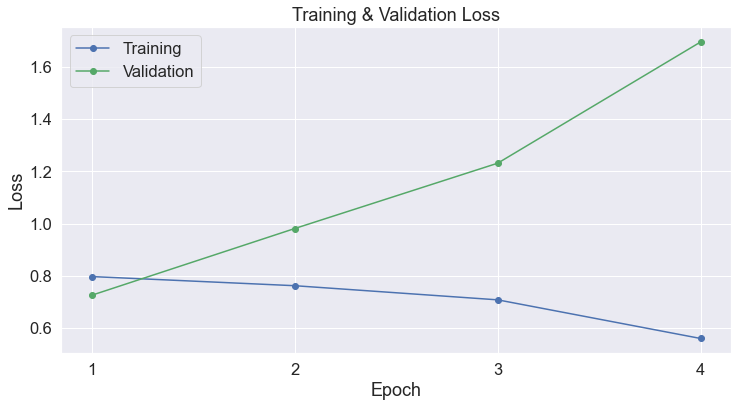

In [25]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [26]:
# Why Validation Loss, not Accuracy?
# Validation loss is a more precise measure than validation accuracy, because with accuracy we don’t care about the exact output value, but just which side of a threshold it falls on.
# If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.